# Visual Map Prediction

## About

Author: [Noah C. Benson](mailto:nben@uw.edu)

eScience Institute  
University of Washington  
Seattle, WA 98195

This notebook contains code and explanations for the modeling and prediction of visual-field PRF parameters in the visual cortex. The "Visual Model" section below lays out the various calculations involved in modeling the visual field parameters using PyTorch.

## Visual Model

### Utility Functions

#### General Utility Functions

In [60]:
def safesqrt(u):
    '''
    safesqrt(u) is equivalent to torch.sqrt(u) but only operates on values that
      are greater than 0.
    '''
    u = u + 0
    ii = u > 0
    u[ii] = torch.sqrt(u[ii])
    return u
def lbeta(a,b):
    '''
    lbeta(a,b) yields the log of the Beta function of x.
    This is equivalent to lgamma(a) + lgamma(b) - lgamma(a+b) using the lgamma
    function from pytorch.
    '''
    return torch.lgamma(a) + torch.lgamma(b) - torch.lgamma(a+b)
def beta_dist(mu, scale):
    '''
    beta_dist(mu, scale) yields the pytorch beta-distribution object(s) for the
      given mean mu and scale. The mu parameter must be between 0 and 1, and
      the scale parameter may be any real number.
      
    The traditional beta distribution uses parameters a and b. The
    reparameterizatoin of mu and scale here is as follows:
      a = (mu * (2 - b) - 1) / (mu - 1)
      b = (2 - 1/mu) + exp(scale)
    '''
    from torch.distributions import Beta
    b = torch.exp(scale)
    a = (mu * (b - 2) + 1) / (1 - mu)
    return Beta(a, b)
def beta_log_prob(mu, scale, x):
    '''
    beta_log_prob(mu, scale, x) yields the log probability density of the beta
      distribution parameterized using the mean mu (which must be between 0 and
      1) and scale (which may be any real number) at the value x.
      
    The traditional beta distribution uses parameters a and b. The
    reparameterizatoin of mu and scale here is as follows:
      a = (mu * (2 - b) - 1) / (mu - 1)
      b = (2 - 1/mu) + exp(scale)
    '''
    dist = beta_dist(mu, scale)
    return dist.log_prob(x)
def beta_pdf(mu, scale, x):
    '''
    beta_pdf(mu, scale, x) yields the probability density function of the beta
      distribution parrameterized using the mean mu (which must be between 0 and
      1) and scale (which may be any real number) at the value x.
    
    The traditional beta distribution uses parameters a and b. The
    reparameterizatoin of mu and scale here is as follows:
      a = (mu * (2 - b) - 1) / (mu - 1)
      b = (2 - 1/mu) + exp(scale)
    '''
    return torch.exp(beta_log_prob(mu, scale, x))
def limit_param(param, min=-1, max=1):
    '''
    limit_param(q) yields the parameter q rescaled to be in the range -1 to 1.
    limit_param(q, min, max) uses the given minimum and maximum parameters.
    '''
    import torch
    return min + (max - min) * (0.5 + torch.atan(param)/np.pi)
def unlimit_param(param, min=-1, max=1):
    '''
    unlimit_param(q, ...) is the inverse of limit_param(q, ...).
    '''
    import torch
    return torch.tan(np.pi * ((param - min) / (max - min) - 0.5))
def triarea(a,b,c):
    '''
    triarea(a,b,c) yields the area of the triangle whose sides have lengths
      a, b, and c.
    '''
    hp = 0.5*(a + b + c)
    return hp * (hp - a) * (hp - b) * (hp - c)
def dist2(xa,ya, xb,yb):
    '''
    dist2(xa,ya, xb,yb) yields the square distance between points a and b.
    '''
    return (xb - xa)**2 + (yb - ya)**2
def dist(xa,ya, xb,yb):
    '''
    dist(xa,ya, xb,yb) yields the distance between points a and b.
    '''
    return safesqrt(dist2(xa,ya,xb,yb))
def trisides2(xa,ya, xb,yb, xc,yc):
    '''
    trisides2(xa,ya, xb,yb, xc,yc) yields the squared lengths of the sides of
      the triangles formed by the given coordinates.
    '''
    return (dist2(xb,yb, xc,yc),
            dist2(xc,yc, xa,ya),
            dist2(xa,ya, xb,yb))
def trisides(xa,ya, xb,yb, xc,yc):
    '''
    trisides(xa,ya, xb,yb, xc,yc) yields the lengths of the sides of the
      triangles formed by the given coordinates.
    '''
    (a2,b2,c2) = trisides2(xa,ya, xb,yb, xc,yc)
    return (safesqrt(a2),
            safesqrt(b2),
            safesqrt(c2))
def trialtitudes(area, sides):
    '''
    trialtitudes(area, (a,b,c)) yields (ha, hb, hc), the altitudes of each
      side associated with the side-lengths, a,b,c.
    '''
    (a,b,c) = sides
    return (2*area/a, 2*area/b, 2*area/c)
def totensor(u, **kw):
    '''
    totensor(u) yields u if u is a pytorch tensor; otherwise, converts u to a
      pytorch tensor and yields that tensor. Keyword arguments to the tensor
      function may be passed, and, if passed, a copy of the u is always made
      when u is a tensor.
    '''
    import torch
    if torch.is_tensor(u):
        if len(kw) == 0: return u
        u = u.detach().numpy()
    dtype = kw.get('dtype', None)
    if dtype is None or dtype is torch.float:
        u = np.array(u, dtype='=f')
    else:
        tmp = torch.tensor(0.0, dtype=dtype)
        tmp = tmp.detach().numpy().dtype
        u = np.array(u, dtype=tmp)
    return torch.tensor(u, **kw)
def branch(iftensor, thentensor, elsetensor=None):
    '''
    branch(q, t, e) yields, elementwise for the given tensors, t if q else e.
    branch(q, t) or branch(q, t, None) yields, elementwise, t if q else 0.
    branch(q, None, e) yields, elementwise, 0 if q else e.
    
    The output tensor will always have the same shape as q. The values for t
    and e may be constants or tensors the same shape as q.

    This function should be safe to use in optimization, i.e., for gradient
    calculatioins.
    '''
    q = totensor(iftensor)
    t = None if thentensor is None else totensor(thentensor)
    e = None if elsetensor is None else totensor(elsetensor)
    x = t if e is None else e
    if x is None: raise ValueError('branch: both then and else cannot be None')
    r = torch.zeros(q.shape, dtype=x.dtype)
    if t is not None:
        if t.shape == (): r[q] = t
        else:             r[q] = t[q]
    if e is not None:
        q = ~q
        if e.shape == (): r[q] = e
        else:             r[q] = e[q]
    return r
def zinv(x):
    '''
    zinv(x) yields 0 if x == 0 and 1/x otherwise. This is done in a way that
      is safe for torch gradients; i.e., the gradient for any element of x that
      is equal to 0 will also be 0.
    '''
    x = totensor(x)
    ii = (x != 0)
    rr = torch.zeros(x.shape, dtype=x.dtype)
    rr[ii] = 1 / x[ii]
    return rr

#### Potential Steps and Wells

In [61]:
_area_stddev = 0.682689
def sin_step(t, width=1, min=0, max=1, center=0):
    '''
    sin_step(t) yields a sin-based sigmoid step such that:
      for t < -w0, sin_step(t) = 0, 
      for t > w0, sin_step(t) = 1,
      otherwise sin_step(t) = 1/2 (1 + sin(pi/2 w0 t)).
    sin_step(t, width) uses the given width; equivalent to sin_step(t/width).
    sin_step(t, width, min, max) uses the given min and max values instead of 0
      and 1.
    sin_step(t, width, min, max, center) centers the distribution at the given
      center value.
      
    The value w0 is based on the value s = 0.682689: approximately the fraction
    of the normal distribution within 1 standard deviation. The actual value of
    w0 is 2 arcsin(s) / pi; this particular value aligns the sin_step with the
    erf_step in that it ensures that ~68% of the distribution for which
    sin_step is the CDF is within -1 to +1.
    
    The sin_well is analogous to the sin_step; though the two are not related
    as PDF/CDF as with other *_well and *_step functions.
    '''
    import torch
    if center != 0: t = t - center
    t = t * (sin_step._w0 / width)
    step = 0.5 + 0.5*torch.sin(np.pi/2*t)
    step[t >  1] = 1
    step[t < -1] = 0
    return min + (max - min)*step
sin_step._w0 = 2.0 * np.arcsin(_area_stddev) / np.pi
def cauchy_step(t, width=1, min=0, max=1, center=0):
    '''
    cauchy_step(t) yields (pi + atan(pi/2 w0 t)) / (2 pi).
    cauchy_step(t, width) uses the given width parameter, equivalent to
      cauchy_step(t/width)
    cauchy_step(t, width, min, max) use the given min and max values, 
      equivalent to cauchy_step(t, width) * (max - min) + min.
      
    The value w0 is based on the value s = 0.682689: approximately the fraction
    of the normal distribution within 1 standard deviation. The actual value of
    w0 is tan(pi/2 s); this particular value aligns the atan_step with the
    erf_step in that it ensures that ~68% of the distribution for which
    atan_step is the CDF is within -1 to +1.
    
    The cauchy_well is analogous to the atan_step.
    '''
    t = totensor(t) - center
    const = cauchy_step._w0 / width
    u = 0.5 + torch.atan(t * const) / np.pi
    return u*(max - min) + min
cauchy_step._w0 = np.tan(np.pi/2 * _area_stddev)
def normal_step(t, width=1, min=0, max=1, center=0):
    '''
    normal_step(t) yields (1 + erf(t/w0))/2.
    normal_step(t, width) uses the given width parameter, equivalent to
      atansigmoid(t/width)
    normal_step(t, width, min, max) use the given min and max values, 
      equivalent to atansigmoid(t, width) * (max - min) + min.
    
    The value w0 is based on the value s = 0.682689: approximately the fraction
    of the normal distribution within 1 standard deviation. The actual value of
    w0 is 1/sqrt(2); this particular value ensures that 68% of the distribution
    for which erf_step is the CDF (i.e., a normal distribution) is within -1 to
    +1.
    
    The erf_step is analogous to the gaussian_well.
    '''
    t = totensor(t) - center
    t *= normal_step._w0 / width
    u = 0.5 + 0.5*torch.erf(t)
    return u * (max - min) + min
normal_step._w0 = 1.0/np.sqrt(2.0)
def logistic_step(t, width=1, min=0, max=1, center=0):
    '''
    logistic_step(t) yields 1/(1 + exp(-w0 t)).
    logistic_step(t, width) uses the given width parameter, equivalent to
      logistic_step(t/width)
    logistic_step(t, width, min, max) use the given min and max values, 
      equivalent to logistic_step(t, width) * (max - min) + min.
    
    The value w0 is based on the value s = 0.682689: approximately the fraction
    of the normal distribution within 1 standard deviation. The actual value of
    w0 is log(-(s+1)/(s-1)); this particular value aligns the logistic_step
    with the erf_step in that it ensures that ~68% of the distribution for which
    atan_step is the CDF is within -1 to +1.
    
    The logistic_step is analogous to the logistic_well.  
    '''
    t = totensor(t) - center
    t *= logistic_step._w0 / width
    u = 1/(1 + torch.exp(-t))
    return u * (max - min) + min
logistic_step._w0 = np.log(-(_area_stddev + 1) / (_area_stddev - 1))

In [62]:
_normaldist_hwhm = np.sqrt(np.log(4.0))
def sin_well(t, width=1, min=0, max=1, center=0):
    '''
    sin_well(t) yields a sin-based well function such that:
      * for t < -1/w0, sin_well(t) = 1
      * for -1/w0 <= t < 1/w0, sin_well(t) = 1/2 (1 - cos(pi/2 w0 t))
      * for 1/20 <= t, sin_well(t) = 1.
    sin_well(t, width) uses the given width; equivalent to sin_well(width*t); 
      the default value is 1.
    sin_well(t, width, min, max) is equivalent to:
       min + (max - min) * sin_well(t, width)
       
    The value w0 is chosen to make the sin-well approximately similar to a
    Gaussian-well in that the half-maximum point of both wells will be at the
    value log(sqrt(4)), which is where the half-way point occurs for a normal
    distribution. For a sin_well, this value if w0 is 1 / (2 log(sqrt(4))).
       
    sin_well(t) is equivalent to sin_well(t, width=1, min=0, max=1, center=0).
    '''
    import torch
    t = totensor(t) - center
    t *= sin_well._w0 / width
    well = 0.5 - torch.cos(np.pi * t)/2
    well[(t < -1) | (t >= 1)] = 1
    return well * (max - min) + min
sin_well._w0 = 0.5 / _normaldist_hwhm
def normal_well(t, width=1, min=0, max=1, center=0, base=0):
    '''
    normal_well(t) yields 1 - exp(-(t^2)/2).
    normal_well(t, width) is equivalent to normal_well(t / width)
    normal_well(t, width, min, max) is equivalent to
      normal_well(t, width) * (max - min) + min
    '''
    import torch
    t = (totensor(t) - center)
    t *= normal_well._w0 / width
    u = 1 - torch.exp(-0.5 * t**2)
    return u * (max - min) + min
normal_well._w0 = 1.0 #_normaldist_hwhm
def cauchy_well(t, width=1, min=0, max=1, center=0):
    '''
    caucht_well(t) yields 1 - 1/(1 + (w0 t)^2).
    cauchy_well(t, width) is equivalent to cauchy_well(t / width)
    cauchy_well(t, width, min, max) is equivalent to
      cauchy_well(t, width) * (max - min) + min.
      
    The value w0 is chosen to make the cauchy-well approximately similar to a
    Gaussian-well in that the half-maximum point of both wells will be at the
    value log(sqrt(4)), which is where the half-way point occurs for a normal
    distribution. For a cauchy_well, this value if w0 is 1 / log(sqrt(4)).
       
    cauchy_well(t) is equivalent to
    cauchy_well(t, width=1, min=0, max=1, center=0).
    '''
    t = (totensor(t) - center)
    t *= cauchy_well._w0 / width
    u = 1 - 1/(1 + t**2)
    return min + (max - min) * u
cauchy_well._w0 = 1.0 / _normaldist_hwhm
def logistic_well(t, width=1, min=0, max=1, center=0):
    '''
    logistic_well(t) yields 1 - 4 exp(-t)/(1 + exp(-t)).
    logistic_well(t, width) is equivalent to cauchy_well(t / width)
    logistic_well(t, width, min, max) is equivalent to
      logistic_well(t, width) * (max - min) + min
      
    The value w0 is chosen to make the logistic-well approximately similar to a
    Gaussian-well in that the half-maximum point of both wells will be at the
    value log(sqrt(4)), which is where the half-way point occurs for a normal
    distribution. For a sin_well, this value if w0 is
    log(3 + 2 sqrt(2)) / (2 log(sqt(4)))
       
    logistic_well(t) is equivalent to
    logistic_well(t, width=1, min=0, max=1, center=0).
    '''
    t = (totensor(t) - center)
    t *= logistic_well._w0 / width
    et = torch.exp(-t)
    u = 1 - 4*et/(1 + et)**2
    return u * (max - min) + min
logistic_well._w0 = np.log(3 + 2*np.sqrt(2.0)) / (2 * _normaldist_hwhm)

#### Log Probabilities for Common Distribution

In [63]:
def normal_log_prob(t, width=1, center=0):
    '''
    normal_log_prob(t) yields the log-probability of the normal 
      distribution: -(t^2 + log(2 pi)) / 2.
    normal_log_prob(t, w) is equivalent to normal_log_prob(t) with a standard
      deviation parameter of w; equal to normal_log_prob(t/w) - log(w).
    normal_log_prob(t, w, center) is equivalent to 
      normal_log_prob(t - center, w)
    '''
    t = (totensor(t) - center)
    width = totensor(width)
    t /= width
    return -0.5 * t**2 + normal_log_prob._offset - torch.log(width)
normal_log_prob._offset = -0.5 * torch.log(torch.tensor(2.0 * np.pi))
def cauchy_log_prob(t, width=1, center=0):
    '''
    cauchy_log_prob(t) yields the log-probability of the Cauchy
      distribution: -log(pi (1 + t^2)).
    cauchy_log_prob(t, w) is equivalent to cauchy_log_prob(t) with a width
      argument of w; equal to: -log(pi w (1 + (t/w)^2)).
    cauchy_log_prob(t, w, center) is equivalent to
      cauchy_log_prob(t - center, w).
    '''
    t = (totensor(t) - center)
    t /= width
    return -torch.log(np.pi * width * (t**2 + 1))
def hcauchy_log_prob(t, width=1):
    '''
    hcauchy_log_prob(t) yields the log-probability of the half-Cauchy
      distribution: -log(pi/2 (1 + t^2)).
    hcauchy_log_prob(t, w) is equivalent to hcauchy_log_prob(t) with a width
      argument of w; equal to: -log(pi/2 w (1 + (t/w)^2)).
      
    Note that although the half-Cauchy distribution is only defined on the
    positive real numbers, this function will return a symmetric set of values
    for the negative real numbers.
    '''
    t = totensor(t) / width
    return -torch.log(np.pi/2 * width * (t**2 + 1))
def laplace_log_prob(t, width=1, center=0):
    '''
    laplace_log_prob(t) yields the log-probability of the Laplace
      distribution: -(|t| + log(2))
    laplace_log_prob(t, w) is equivalent to laplace_log_prob(t) with a mean
      parameter of 1/w; equal to -(|t| + log(2 w)).
    laplace_log_prob(t, w, center) is equivalent to
      laplace_log_prob(t - center, w).
    '''
    t = (totensor(t) - center)
    width = totensor(width)
    t /= width
    return -torch.abs(t) - torch.log(2*width)
def exp_log_prob(t, width=1, center=0):
    '''
    exp_log_prob(t) yields the log-probability of the exponential
      distribution: -t for t >= 0 else negative infinity.
    exp_log_prob(t, w) is equivalent to exp_log_prob(t) with a mean argument of
      1/w; equal to: -(t + log(w)) if t > 0 else negative infinity.
    exp_log_prob(t, w, center) is equivalent to exp_log_prob(t - center, w).
    '''
    t = (totensor(t) - center)
    width = totensor(width)
    t /= width
    return branch(t > 0, -t - torch.log(width), -np.inf)
def generr_log_prob(q, t, width=1, center=0):
    '''
    generr_log_prob(q, t) yields the log-probability of the generalized error
      distribution: -|t|^q
    generr_log_prob(q, t, w) is equivalent to generr_log_prob(q, t / w).
    generr_log_prob(q, t, w, c) is equivalent to generr_log_prob(q, t - c, w).
    '''
    t = (totensor(t) - center)
    t /= width
    return -torch.abs(t)**q
def gumbel_log_prob(t, lw=1, rw=1, center=0):
    '''
    gumbel_log_prob(t) yields the log-probability of the standard Gumbel
      distribution: -(t + exp(-t))
    gumbel_log_prob(t, lw) uses the lw for the width of the left-hand side of
      the Gumbel distribution; i.e.: -(t + exp(-t)/lw).
    gumbel_log_prob(t, lw, rw) uses the lw and rw for the widths of the
      left-hand and right-hand side of the Gumbel distribution; i.e.:
      -(t/lr + exp(-t)/lw).
      
    Note that this is not a typical Gumbel distribution definition, but it is a
    very similar distribution nonetheless. Whereas the Gumbel PDF is usually
    defined as being proportional to exp(-((t-t0)/w + exp(-(t-t0)/w))), this
    particular parameterization allows for the linear part of the exponential
    B(T) = t to be scaled separately from the exponential part of the
    exponential A(t) = exp(-t). In a traditional Gumbel distribution,
    the PDF(t) = exp(-[A([t-t0]/w) + B([t-t0]/w)]). In the parameterization
    here, PDF(t) = exp(-[A([t-t0]/a) + B([t-t0]/b)]).
    '''
    t = (totensor(t) - center)
    lw = totensor(lw)
    rw = totensor(rw)
    const = lw*torch.log(rw/lw) + rw*(torch.log(lw) + torch.lgamma(lw/rw))
    return (lw*torch.exp(-t/lw) + t + const) / -rw

### Initializing Subject Data

In [64]:
@pimms.calc('cortex')
def init_hcp_cortex(sid, hemi):
    '''
    Calculation:
      (sid, h) => (cortex)
    Loads an HCP subject with the given subject id (sid), loads the given
    hemisphere (h), and yields it as the value 'cortex'.
    
    Afferent parameters:
     @ sid The HCP subject ID of the subject to use.
     @ hemi The name of the hemisphere to use--typically 'lh' or 'rh'.
    '''
    import neuropythy as ny
    sub = ny.hcp_subject(sid)
    return (sub.hemis[hemi],)
@pimms.calc('prior_angle', 'prior_eccen', 'prior_theta', 'prior_label')
def init_prior(cortex, prior_retinotopy=None, dtype=torch.float, device='cpu'):
    '''
    Calculation:
      (cortex, precalc_prior, dtype) => (prior_{angle,eccen,theta,label})
    Calculates the prior retinotopic maps for the given cortex object.
    
    Afferent parameters:
     @ prior_retinotopy A precalculated prior map as produced by neuropythy's
       predict_retinotopy() function with default options. If provided, the
       calculation of a prior is not needed.
     @ dtype The pytorch type to be used for all tensors (default: 
       torch.float).
     @ device The pytorch device name to be used for all tensors (default:
       'cpu').
    
    Efferent values:
     @ prior_angle The prior polar angle of each vertex on 'cortex' in
       neuropythy's 'visual' coordinate style (positive is clockwise, UVM is
       zero, units are degrees).
     @ prior_theta The prior polar angle of each vertex on 'cortex' in
       neuropythy's 'standard' coordinate style (positive is counter-clockwise,
       RHM is zero, units are radians).
     @ prior_eccen The prior eccentricity of each vertex on 'cotex' in
       visual degrees.
     @ prior_label The prior visual area label of each vertex on
       'cotex' represented as an integer real between 0 and 3 with 1, 2, and 3
       standing for V1, V2, and V3, respectively. Note that the label 0 takes
       on the visual-areea index 4 in the model implementation.
    '''
    import torch, neuropythy as ny
    if prior_retinotopy is None:
        prior_retinotopy = ny.vision.predict_retinotopy(cortex)
    (ang,ecc,lbl) = [np.array(prior_retinotopy[k])
                     for k in ('angle','eccen','varea')]
    tht = np.pi/180 * (np.mod(90 - ang + 180, 360) - 180)
    return (totensor(ang, dtype=dtype).to(device),
            totensor(ecc, dtype=dtype).to(device),
            totensor(tht, dtype=dtype).to(device),
            totensor(lbl, dtype=dtype).to(device))
@pimms.calc('meas_angle', 'meas_eccen', 'meas_theta', 'meas_prfsize',
            'meas_cod', 'meas_x', 'meas_y')
def init_meas(cortex, device, dtype, retinotopy='prf_'):
    '''
    Calculation:
      (cortex, retinotopy, dtype) => (meas_{angle,eccen,theta,prfsize,vexpl})
    Locates the measured retinotopy data.
    
    Afferent parameters:
     @ retinotopy The argument for neuropythy's retinotopy_data function; this
       is typically a string prefix for retinotopy data on the cortex's
       properties ('prf_' for HCP subjects), or a map of the data itself.
    
    Efferent values:
     @ meas_angle The measured polar angle of each vertex on 'cortex' in
       neuropythy's 'visual' coordinate style (positive is clockwise, UVM is
       zero, units are degrees).
     @ meas_theta The measured polar angle of each vertex on 'cortex' in
       neuropythy's 'standard' coordinate style (positive is counter-clockwise,
       RHM is zero, units are radians).
     @ meas_eccen The measured eccentricity of each vertex on 'cotex' in
       visual degrees.
     @ meas_cod The measured variance-explained (COD) of each vertex on
       'cotex' represented as a real number between 0 and 1.
     @ meas_prfsize The measured pRF size of each vertex on 'cotex' in visual
       degrees.
     @ meas_x The measured x coordinate of each vertex.
     @ meas_y The measured y coordinate of each vertex.
    '''
    import torch, neuropythy as ny
    rd = ny.vision.retinotopy_data(cortex, retinotopy)
    ang = np.array(rd['polar_angle'])
    ecc = np.array(rd['eccentricity'])
    vxp = np.array(rd['variance_explained'])
    rfs = np.array(rd['radius'])
    tht = np.pi/180 * (np.mod(90 - ang + 180, 360) - 180)
    # NaNs need to be converted to 0's
    ang[~np.isfinite(ang)] = 0.0
    ecc[~np.isfinite(ecc)] = 0.0
    vxp[~np.isfinite(vxp)] = 0.0
    rfs[~np.isfinite(rfs)] = 0.0
    tht[~np.isfinite(tht)] = 0.0
    x = np.cos(tht) * ecc
    y = np.sin(tht) * ecc
    return (totensor(ang, dtype=dtype).to(device),
            totensor(ecc, dtype=dtype).to(device),
            totensor(tht, dtype=dtype).to(device),
            totensor(rfs, dtype=dtype).to(device),
            totensor(vxp, dtype=dtype).to(device),
            totensor(x, dtype=dtype).to(device),
            totensor(y, dtype=dtype).to(device))
@pimms.calc('full_mesh', 'flatmap', 'mesh')
def init_mesh(cortex,
              meas_angle, meas_eccen, meas_theta, meas_cod, meas_prfsize,
              prior_angle, prior_eccen, prior_theta, prior_label,
              precalc_flatmap=None):
    '''
    Calculation:
      (cortex, prior_*, meas_*, precalc_flatmap) 
        => (full_mesh, flatmap, occpole_mesh)
    Loads the midgray mesh from the cortex object and limits it using a mask
    formed by the vertices in a spotlight flatmap of the occipital pole.
   
    Afferent parameters:
     @ cortex The neuropythy Cortex object (representing a hemisphere) to use.
     @ precalc_flatmap An optional flatmap to use instead of calculating a new
       flatmap using neuorpythy.to_flatmap('occipital_pole', cortex).
    
    Efferent values:
     @ full_mesh The migray mesh for the cortex being modeled.
     @ flatmap A flatmap of the occipital pole that has the same mask as the
       3D mesh on which the model is implemented (occpole_mesh and mesh).
     @ mesh The midgray surface mesh on which the model is implemented,
       limited to a spot-light mask of the occipital pole calculated using
       the vertices in flatmap.
    '''
    cortex = cortex.with_prop(
        prior_polar_angle=prior_angle,
        prior_eccentricity=prior_eccen,
        prior_theta=prior_theta,
        prior_label = prior_label,
        meas_polar_angle=meas_angle,
        meas_eccentricity=meas_eccen,
        meas_theta=meas_theta,
        meas_prfsize=meas_prfsize,
        meas_variance_explained = meas_cod)
    full_mesh = cortex.surface('midgray')
    if precalc_flatmap is None:
        precalc_flatmap = ny.to_flatmap('occipital_pole', cortex)
    else:
        p = dict(prior_polar_angle=prior_angle,
                 prior_eccentricity=prior_eccen,
                 prior_theta=prior_theta,
                 prior_label = prior_label,
                 meas_polar_angle=meas_angle,
                 meas_eccentricity=meas_eccen,
                 meas_theta=meas_theta,
                 meas_prfsize=meas_prfsize,
                 meas_variance_explained = meas_cod)
        for (k,v) in p.items():
            if torch.is_tensor(v): v = v.detach().numpy()
            p[k] = v[precalc_flatmap.labels]
        #p = {k: v[precalc_flatmap.labels] for (k,v) in p.items()}
        precalc_flatmap = precalc_flatmap.with_prop(**p)
    flatmap = precalc_flatmap
    mesh = full_mesh.submesh(flatmap.labels)
    return (full_mesh, flatmap, mesh)
@pimms.calc('faces', 'edges',
            'face_pairs', 'face_pair_edges', 'face_pair_opposites',
            'edge_lengths_mm', 'face_areas_mm2', 'vertex_areas_mm2')
def init_geometry(mesh, dtype, device):
    '''
    Calculation:
      (mesh) => (faces, edges, face_pairs, face_pair_opposites, edge_lenghts_mm,
                 face_areas_mm2, vertex_areas_mm2)
    Loads the midgray mesh from the cortex object and limits it using a mask
    formed by the vertices in a spotlight flatmap of the occipital pole.
   
    Efferent values:
     @ faces The 3 x n numpy arrary of the mesh vertex indices of each corner
       of its faces.
     @ edges The 2 x n numpy arrary of vertex indices in the mesh for each edge
       endpoint.
     @ face_pairs The 2 x n numpy array whose columns represent face indices
       are adjacent to each other. The indices of the edges that lie between
       each face pair is given by face_pair_edges.
     @ face_pair_edges The numpy array of edge indices that match the face
       pairs in the 'face_pairs' value. Each pair of faces that share an
       edge is given by the face inidices in face_pairs[k] and the edge 
       between them is given by the edge index in face_pair_edges[k].
     @ face_pair_opposites The 2 x n numpy array of mesh vetex indices of the
       vetices opposite each face in the face_pairs index. For a column k of
       face_pairs, the face indexed by face_pairs[k][0] is across the edge
       indexed by face_pair_edges[k] from the vertex indexed by
       face_pair_opposites[k][0]. The same is true for the face given by 
       ...[k][1].
     @ edge_lengths_mm The lengths of each edge in mesh in mm.
     @ face_areas_mm2 The cotical surface area of each face in mesh in square
       mm.
     @ vertex_areas_mm2 The cortical suface area of each vertex in mesh in
       square mm.
    '''
    edges = mesh.tess.indexed_edges.T
    faces = mesh.tess.indexed_faces.T
    # Figure out the face-pairs.
    (fp1,fp2,fp_edges) = np.transpose(
        [(k[0],k[1],ii) for (ii,k) in enumerate(mesh.tess.edge_faces) if len(k) == 2])
    fps = np.array([fp1,fp2])
    face_pairs = fps.T
    f1other = np.squeeze([faces[f1, ~np.isin(faces[f1], faces[f2])]
                          for (f1,f2) in face_pairs])
    f2other = np.squeeze([faces[f2, ~np.isin(faces[f2], faces[f1])]
                          for (f1,f2) in face_pairs])
    fp_opps = np.array([f1other, f2other])
    fps = face_pairs.T
    # Get the edge lengths and triangle surface areas from the midgray surface.
    els = totensor(mesh.edge_lengths, dtype=dtype).to(device)
    fas = totensor(mesh.face_areas, dtype=dtype).to(device)
    vas = totensor(mesh.prop('midgray_surface_area'), dtype=dtype).to(device)
    return (faces.T, edges.T, fps, fp_edges, fp_opps, els, fas, vas)

init_subject_plan = pimms.plan(
    {'hcp_cortex': init_hcp_cortex,
     'prior':      init_prior,
     'meas':       init_meas,
     'mesh':       init_mesh,
     'geometry':   init_geometry})

### The Retinotopy Model

#### Angle Coefficients

##### Explanation

Polar angle and visual area are stored simultaneously in one value: the angle coefficient. Angle coefficients range from -4 to 4 with the values indicating the following:
* `-1` and `+1` represent the LVM and UVM of V1, respectively (`0` represents the HM of V1).
* `-2` and `+2` represent the dorsal and ventral HM of V2/V3, respectively.
* `-3` and `+3` represent the LVM and UVM of V3, respectively.
* The remainder (out to `±4`) are buffer areas.

Conversion between an angle coefficient and a polar angle is done with the formula parameters:
* `uvm_ipsilateral` (also represented as `ui`) is the deviation of the UVM polar angle from the true vertical (&pi;/2). For example if this value is 0.07, then the polar angle values of the upper vertical meridian are expected to be (&pi;/2 + 0.07).
* `lvm_ipsilateral` (also represented as `li`) is the same deviation for the LVM polar angle from the true vertical (&pi;/2). Whereas the UVM value is given in counter-clockwise radians, this value is given in clockwise radians.
* `angle_sigma` is a value that determines the bleedover between visual areas at the boundaries. Because we propose to fit the model to the data using gradient descent optimization, we don't want hard visual-area boundaries at the V1/V2, V2/V3, etc. edges. Accordingly, vertices near the edges are considered to be a weighted combination of both visual areas with the higher weight for the area that is closer. The weights are determined by step-like functions that employ the error-function as a sigmoid.

The following visual-area values can be computed using the above `angle_sigma` parameter and the angle coefficients. For angle coefficient $t$, the following are the visual-area pseudo-labels:
* $w(t; \sigma, s_0, s_1) = \frac{1}{2}\left(\hbox{erf}\left((t + s_0)/\sigma\right) - \hbox{erf}\left((t - s_1)/\sigma\right)\right)$
* $v_1(t; \sigma) = w(t; \sigma, -1, 1)$
* $v_2(t; \sigma) = w(t; \sigma, -2, -1) + w(t; \sigma, 1, 2)$
* $v_3(t; \sigma) = w(t; \sigma, -3, -2) + w(t; \sigma, 2, 3)$
* $v_4(t; \sigma) = w(t; \sigma, -4, -3) + w(t; \sigma, 3, 4)$

Given these values, we can calculate the predicted angle value for an angle coefficient. The formula for the predicted polar angle $\theta$, calculated from the angle coefficient $t$ using parameters $u$ (`uvm_ipsilateral`) and $l$ (`lvm_ipsilateral`) and the visual-area label $q$ (which must be 1, 2, 3, or 4) is as follows:

$$
\bar{\theta}(t; u, l, q) = \begin{cases}
    (\pi/2 + u) (t - q + 1) & \mbox{if}\;\; t > 0 \\
    (\pi/2 + l) (t + q - 1) & \mbox{if}\;\; t \leq 0
    \end{cases}
$$

The predicted polar angle for a specific angle coefficient can be found by summing across visual areas with the window functions as weights:

$$
\theta(t; \sigma, u, l) = \sum_{k=1}^4 v_k(t; \sigma) \bar{\theta}(t; u, l, k)
$$

##### Core Funnctions

In [65]:
def varea_window(t, sigma, s0, s1):
    '''
    varea_window(t, sigma, s0, s1) is a smooth step-function described by:
       𝑤(𝑡; 𝜎, 𝑠0, 𝑠1) = 1/2 (erf((𝑡+𝑠0)/(2𝜎/π)) − erf((𝑡−𝑠1)/(2𝜎/π)))
    or:
       0.5 * (erf((t + s0)/(sigma/pi*2)) - erf((t - s1) / (sigma/pi*2)))
       
    Note that sigma is divided by pi/2 because it is assumed to be expressed in
    radians whereas there are approximately pi radians in 2 units of the
    theta-coefficient t.
    '''
    sigma = sigma / (np.pi / 2)
    return 0.5 * (torch.erf((t - s0) / sigma) - torch.erf((t - s1) / sigma))
def varea_1(t, label_sigma=0.1):
    '''
    varea_1(t, sigma) yields the v1 label weight for theta-coefficient t.
    '''
    return varea_window(t, label_sigma, -1.0, 1.0)
def varea_2(t, label_sigma=0.1):
    '''
    varea_2(t, sigma) yields the v2 label weight for theta-coefficient t.
    '''
    return varea_window(t, label_sigma, -2.0, -1.0) + varea_window(t, label_sigma, 1.0, 2.0)
def varea_3(t, label_sigma=0.1):
    '''
    varea_3(t, sigma) yields the v3 label weight for theta-coefficient t.
    '''
    return varea_window(t, label_sigma, -3.0, -2.0) + varea_window(t, label_sigma, 2.0, 3.0)
def varea_4(t, label_sigma=0.1):
    '''
    varea_4(t, sigma) yields the v4-like label weight for theta-coefficient t.
    '''
    return 1.0 - varea_window(t, label_sigma, -3.0, 3.0)
def vareas(t, label_sigma=0.1):
    '''
    Yields a 5-tuple of (varea_1, varea_2, varea_3, varea_4, varea_sum).
    '''
    ws = (varea_1(t, label_sigma=label_sigma),
          varea_2(t, label_sigma=label_sigma),
          varea_3(t, label_sigma=label_sigma),
          varea_4(t, label_sigma=label_sigma))
    wtot = ws[0] + ws[1] + ws[2] + ws[3]
    return ws + (wtot,)
def _bartheta(t, q, ui=0.09, li=0.17):
    '''
    _bartheta(t, q) calculates the piecewise bar-theta parameter (see above cells).
    '''
    hpi = np.pi/2
    gt = t > 0
    le = ~gt
    res = torch.zeros(t.shape)
    if q > 0:
        res[gt] = (hpi + ui) * (t[gt] - q + 1)
        res[le] = (hpi + li) * (t[le] + q - 1)
    else:
        q *= -1
        res[gt] = (hpi + ui) * (1 - (t[gt] - q + 1))
        res[le] = (hpi + li) * (-1-(t[le] + q - 1))
    return res
def theta(t, vas, ui=0.09, li=0.17):
    '''
    theta(t,vas) calculates the polar angle theta from the angle-coefficient t
      and the visual areas vas (see vareas()). The return value is in radians
      that increase in the counter-clockwise direction with 0 as the RHM.
    '''
    return (vas[0]*_bartheta(t,  1, ui=ui, li=li) +
            vas[1]*_bartheta(t, -2, ui=ui, li=li) +
            vas[2]*_bartheta(t,  3, ui=ui, li=li) +
            vas[3]*_bartheta(t, -4, ui=ui, li=li) ) / vas[4]
def theta_rescaled(t, vas):
    '''
    theta_rescaled(t, vas) is equivalent to theta(t, vas) except that it
      excludes any upper or lower visual-field ipsilateral stretching. This
      value is appropriate for use with the cortical magnification model.
    '''
    return (vas[0]*_bartheta(t,  1, ui=0, li=0) +
            vas[1]*_bartheta(t, -2, ui=0, li=0) +
            vas[2]*_bartheta(t,  3, ui=0, li=0) +
            vas[3]*_bartheta(t, -4, ui=0, li=0) ) / vas[4]
def theta_spiral(t, ui=0.09, li=0.17):
    '''
    theta_spiral(t, ui, li) yields a spiral version of theta that has
      the same fieldsign everywhere (i.e., always increases in the ventral
      direction and always decreases in the dorsal direction) but for which the
      cortical magnification is preserved.
    
    The parameter t should be the anglecoef, and the ui and li should be
    positive real numbers.
    '''
    hpi = np.pi/2
    gt = t > 0
    le = ~gt
    vas = abs(t)
    vas = [(vas >= k) & (vas < k+1) for k in [0,1,2]]
    vas.append(torch.logical_not(vas[0] + vas[1] + vas[2]))
    res = torch.zeros(t.shape)
    for (q,va) in zip([1,2,3,4], vas):
        gtva = gt & va
        leva = le & va
        res[gtva] = (hpi + ui) * (t[gtva])
        res[leva] = (hpi + li) * (t[leva])
    return res
def prior_anglecoef(angles, vareas):
    '''
    prior_anglecoef(angles, vareas) yields the angle coefficients of the
      polar angles and visual area labels. Note that this is expected to
      be called with arguments from the retinotopic prior or similar, so
      angles should be in 'visual' orientation (clockwise is positive,
      UVM is 0°) and vareas should be a vector of labels (1 for V1, 2
      for V2, etc.)
    
    Yields torch tensors.
    '''
    if torch.is_tensor(angles): angles = angles.detach().numpy()
    if torch.is_tensor(vareas): vareas = vareas.detach().numpy()
    angles = (np.mod(90 - angles + 180, 360) - 180) / 90
    c = torch.full(np.shape(angles), 4.0, dtype=torch.float)
    q = np.ones(c.shape, dtype='bool')
    for (ll,ks,sgn) in zip([1,2,3,4,4], [[1],[2],[3],[4],[7,11,12]],
                           [1,0,1,4,-4]):
        ii = np.isin(vareas, ks)
        q[ii] = False
        angs = angles[ii]
        if   sgn == 0:  tns = np.sign(angs)*ll - angs
        elif sgn == 1:  tns = np.sign(angs)*(ll - 1) + angs
        elif sgn == 4:  tns = 4 - angs
        elif sgn == -4: tns = -4 - angs
        c[ii] = torch.tensor(tns, dtype=torch.float)
    # Fill in the rest as ± 4's.
    sgns = np.sign(angles[q])
    sgns[sgns == 0] = 1
    c[q] = torch.tensor(4.0 * sgns, dtype=torch.float)
    return c

##### Demo

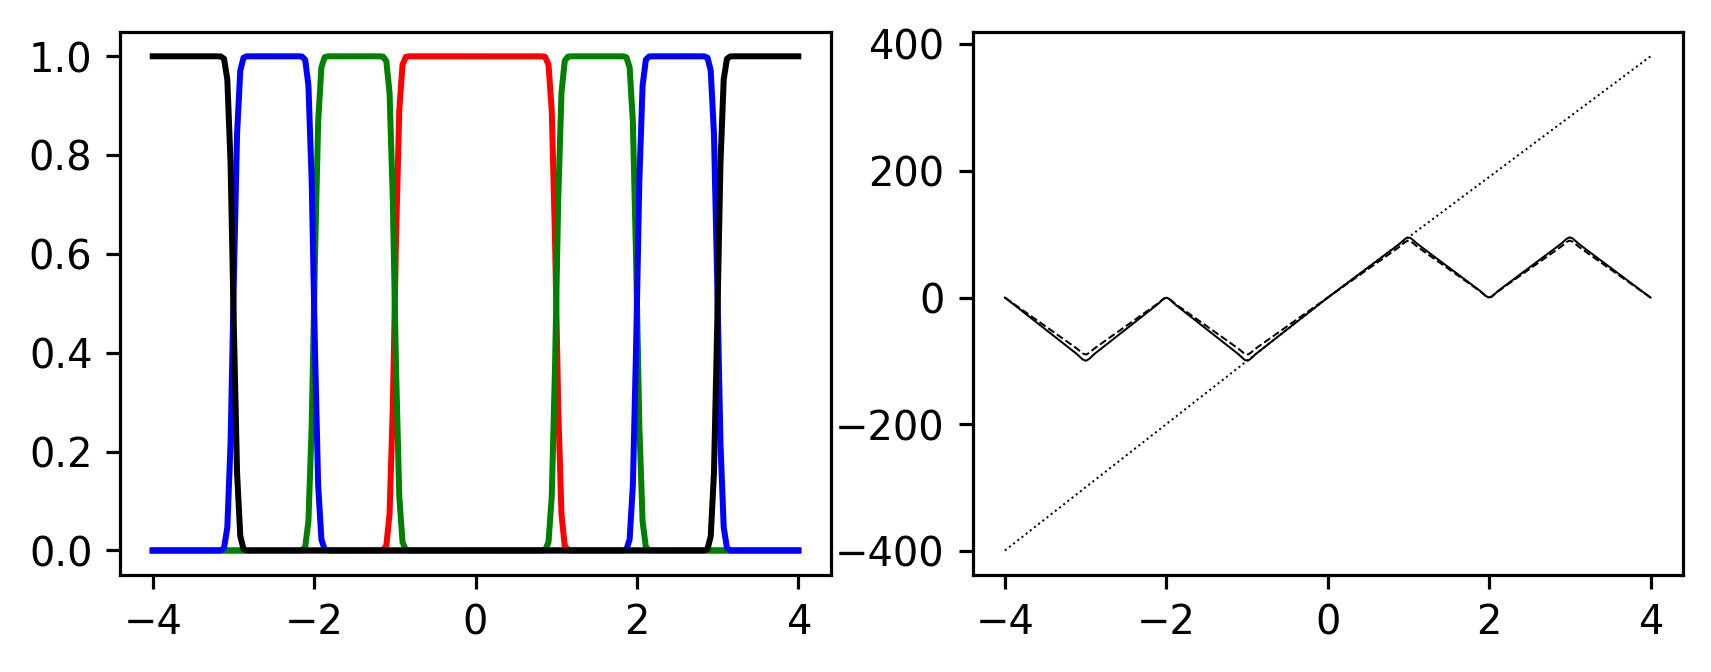

In [66]:
(fig,axs) = plt.subplots(1, 2, figsize=(7, 2.5), dpi=72*4)

x = torch.tensor(np.linspace(-4.0, 4.0, 200), dtype=torch.float)
vas = vareas(x)
ax = axs[0]
ax.plot(x, vas[0], 'r-')
ax.plot(x, vas[1], 'g-')
ax.plot(x, vas[2], 'b-')
ax.plot(x, vas[3], 'k-')

ax = axs[1]
ax.plot(x, 180/np.pi*theta(x, vas), 'k-', lw=0.5)
ax.plot(x, 180/np.pi*theta_rescaled(x, vas), 'k--', lw=0.5)
ax.plot(x, 180/np.pi*theta_spiral(x), 'k:', lw=0.5)

pass

##### Calculation and Plan Code

In [67]:
@pimms.calc('anglecoef', 'eccen')
def init_coords(prior_angle, prior_eccen, prior_label, mesh,
                dtype, device, coords_grad=True, gradients={}):
    '''
    Calculation:
      (prior_angle, prior_eccen, prior_label, coords_grad) 
        => (anglecoef, eccen)
    Converts the prior polar angle, eccentricity, and visual area label into
    the initial angle-coefficient and eccentricity values to be used in the
    model calculation and, potentially, minimization.
    
    Afferent parameters:
     @ coords_grad True if the polar angle and eccentricity coordinates
       represented in anglecoef and eccen should have required gradient
       calculations. The default is True. If False, this essentially means that
       any minimization that is performed will not attempt to optimize the
       individual vertex parameters.
     @ gradients A (mutable) dict of pytorch tensors produced during the
       initialization of the model code for which gradient calculations were
       required. Duing initialization, various calculations append to this
       gradient with their parameter names as keys. If the entire model is
       run, i.e., by requesting the potential, then this dictionary will
       contain all the parameters that depend on a gradient. These may be
       touched in the imap to force recalculation of the potential values
       and meta-data when optimizing.
    
    Efferent values:
     @ anglecoef The pytorch tensor containing the angle-coefficient for each
       vertex in mesh. The angle coefficient is a shorthand for representing
       the range of polar angles and visual areas in V1, V2, and V3 and is
       explained in more detail in the notebook that accompanies this code.
     @ eccen The pytorch tensor containing the eccentricity of each vertex in
       mesh.
    '''
    ang = prior_anglecoef(prior_angle, prior_label)
    ecc = prior_eccen.detach().numpy()[mesh.labels]
    ang = ang.detach().numpy()[mesh.labels]
    ang = totensor(ang, dtype=dtype, requires_grad=coords_grad).to(device)
    ecc = totensor(ecc, dtype=dtype, requires_grad=coords_grad).to(device)
    if coords_grad:
        gradients['anglecoef'] = ang
        gradients['eccen'] = ecc
    return (ang, ecc)
@pimms.calc('uvm_ipsilateral_free', 'lvm_ipsilateral_free',
            'hva_free', 'vma_free', 'label_sigma_free')
def init_anglecoef_params(dtype, device, gradients,
                          prior_uvm_ipsilateral=0.09,
                          prior_lvm_ipsilateral=0.17,
                          prior_hva=0.5,
                          prior_vma=0.5,
                          prior_label_sigma=0.10,
                          uvm_ipsilateral_lim=(-0.3,0.3),
                          lvm_ipsilateral_lim=(-0.3,0.3),
                          hva_lim=(-1.0,1.0),
                          vma_lim=(-1.0,1.0),
                          label_sigma_lim=(0.01, 0.5),
                          ipsilateral_grad=False,
                          asymmetry_grad=False,
                          label_sigma_grad=False):
    '''
    Initializes the model parameters required to interpret the 
    angle-coefficient of each vertex into polar angle and visual area label
    properties. This calculation initializes the "free" versions of the
    parameters--i.e., the versions that can range from -inf to inf but that get
    limited into a particular range for the actual model calculation.
    
    Afferent parameters:
     @ prior_uvm_ipsilateral The initial value of the UVM ipsilateral visual
       field fraction in the retinotopy model.
     @ prior_lvm_ipsilateral The initial value of the LVM ipsilateral visual
       field fraction in the retinotopy model.
     @ prior_hva The initial value of the horizontal-vertical asymmetry ratio
       in the model. This is conceptually:
       2 (horiz_cmag - vert_cmag) / (horiz_cmag + vert_cmag)
     @ prior_vma The initial value of the horizontal-vertical asymmetry ratio
       in the model. This is conceptually:
       2 (lower_cmag - upper_cmag) / (lower_cmag + upper_cmag)
     @ prior_label_sigma The initial value of the visual areal label's sigma
       value. This controls how much the properties of one visual area bleeds
       into the next visual area at the boundaries.
     @ uvm_ipsilateral_lim The (min, max) values that the uvm_ipsilateral
       parameter is allowed to take in the retinotopy model.
     @ lvm_ipsilateral_lim The (min, max) values that the lvm_ipsilateral
       parameter is allowed to take in the retinotopy model.
     @ hva_lim The (min, max) values that the hva parameter is allowed to take
       in the retinotopy model.
     @ vma_lim The (min, max) values that the vma parameter is allowed to take
       in the retinotopy model.
     @ label_sigma_lim The (min, max) values that the label_sigma parameter is
       allowed to take in the retinotopy model.
     @ ipsilateral_grad True if the uvm and lvm ipsilateral representation
       parameters should be updated in gradient steps; otherwise, the
       parameters are treated as constants.
     @ asymmetry_grad True if the hva and vma (asymmetry) parameters should be
       updated in gradient steps; otherwise, the parameters are treated as
       constants.
     @ label_sigma_grad True if the label_sigma parameter should be updated in
       gradient steps; otherwise, the parameter is treated as a constant.
       
    Efferent values:
     @ uvm_ipsilateral_free The free/unlimited version of the UVM ipsilateral
       fraction parameter. As a free parameter, the value may be any real
       number; the limited version is calculated using the CDF of a normal
       distribution.
     @ lvm_ipsilateral_free The free/unlimited version of the LVM ipsilateral
       fraction parameter. As a free parameter, the value may be any real
       number; the limited version is calculated using the CDF of a normal
       distribution.
     @ hva_free The free/unlimited version of the horizontal-vertical asymmetry
       parameter. As a free parameter, the value may be any real number; the
       limited version is calculated using the CDF of a normal distribution.
     @ vma_free The free/unlimited version of the upper-lower vertical
       asymmetry parameter. As a free parameter, the value may be any real
       number; the limited version is calculated using the CDF of a normal
       distribution.
     @ label_sigma_free The free/unlimited version of the label_sigma
       parameter. As a free parameter, the value may be any real number; the
       limited version is calculated using the CDF of a normal distribution.
    '''
    tups = [
        ('uvm_ipsilateral_free', uvm_ipsilateral_lim, prior_uvm_ipsilateral, ipsilateral_grad),
        ('lvm_ipsilateral_free', lvm_ipsilateral_lim, prior_lvm_ipsilateral, ipsilateral_grad),
        ('hva_free',             hva_lim,             prior_hva,             asymmetry_grad),
        ('vma_free',             vma_lim,             prior_vma,             asymmetry_grad),
        ('label_sigma_free',     label_sigma_lim,     prior_label_sigma,     label_sigma_grad)]
    rval = {}
    for (k,(mn,mx),pri,grad) in tups:
        pri_free = unlimit_param(totensor(pri), mn, mx)
        u = torch.tensor(pri_free.detach().numpy(),
                         dtype=dtype,
                         requires_grad=grad)
        u = u.to(device)
        if grad: gradients[k] = u
        rval[k] = u
    return rval
@pimms.calc('uvm_ipsilateral', 'lvm_ipsilateral',
            'hva', 'vma', 'label_sigma')
def calc_anglecoef_params(uvm_ipsilateral_free,
                          lvm_ipsilateral_free,
                          hva_free,
                          vma_free,
                          label_sigma_free,
                          uvm_ipsilateral_lim,
                          lvm_ipsilateral_lim,
                          hva_lim,
                          vma_lim,
                          label_sigma_lim):
    '''
    Calculates the model parameters required to interpret the 
    angle-coefficient of each vertex into polar angle and visual area label
    properties from the free (unlimited/gradient-safe) parrameters. This
    calculation involves running the free versions of each pameter through the
    arctangent function in order to convert an infinite range to the range
    (0,1) then linearly expanding that to the parameter's limit.
    
    Efferent values:
     @ uvm_ipsilateral The range-limited translation of uvm_ipsilateral_free
       based on uvm_ipsilateral_lim. The UVM ipsilateral fraction is the
       fraction of the ipsilateral visual field that is represented along the
       ventral visual area boundaries in cortex.
     @ lvm_ipsilateral The range-limited translation of lvm_ipsilateral_free
       based on lvm_ipsilateral_lim. The LVM ipsilateral fraction is the
       fraction of the ipsilateral visual field that is represented along the
       dorsal visual area boundaries in cortex.
     @ hva The range-limited translation of hva_free based on hva_lim. The
       horizontal-vertical asymmetry is conceptually:
       2 (horiz_cmag - vert_cmag) / (horiz_cmag + vert_cmag)
     @ vma The range-limited translation of hva_free based on vma_lim. The
       vertical meridian asymmetry is conceptually:
       2 (lower_cmag - upper_cmag) / (lower_cmag + upper_cmag)
     @ label_sigma The range-limited translation of label_sigma_free based on
       label_sigma_lim. The label_sigma is the constant multiplier used in
       the error-function (erf) used to calculate visual area weights. See
       the calc_anglecoef_metaparams calculator for more details.
    '''
    tups = [
        (uvm_ipsilateral_lim, uvm_ipsilateral_free),
        (lvm_ipsilateral_lim, lvm_ipsilateral_free),
        (hva_lim,             hva_free),
        (vma_lim,             vma_free),
        (label_sigma_lim,     label_sigma_free)]
    (uvmi, lvmi, hva, vma, lsig) = [limit_param(free, mn, mx)
                                    for ((mn,mx),free) in tups]
    return (uvmi, lvmi, hva, vma, lsig)
@pimms.calc('theta', 'theta_rescaled', 'theta_spiral', 'varea_weights')
def calc_anglecoef_data(anglecoef, label_sigma,
                        uvm_ipsilateral, lvm_ipsilateral,
                        dtype, device):
    '''
    Calculates the values theta, theta_rescaled, and the visual-area weights
    (varea_weights) for each vertex in the model based on the angle-coefficient
    and the model parameters label_sigma, and uvm_/lvm_ipsilateral.
    
    Efferent values:
     @ theta The predicted "true" polar angle representation of the pRF of each
       vertex in the retinotopy model. The value is in radians with the RHM at
       0 and positive pointing in the counter-clockwise direction.
     @ theta_rescaled The predicted polar angle rescaled to be contained in the
       right horizontal visual field; this is occasionally useful when polar
       angle is part of a model, but the UVM/LVM ipsilateral fraction isn't
       explicitly part of the subcomponent of the model.
     @ varea_weights A 4-tuple of the (non-visual, v1, v2, v3) area weights of
       the model. The weight for each area is the predicted fraction of the
       vertex that is classified as part of the relevant visual area.
     @ theta_spiral A translation of the polar angle variable theta such that
       the areal, tangential, and radial cortical magnifications of all faces
       are the same when calculated using either theta or theta_spiral, but the
       polar angle increases continuously as one moves dorsally across cortex
       decreases continuously as one moves ventrally across cortex.
    '''
    vas = vareas(anglecoef, label_sigma=label_sigma)
    tht = theta(anglecoef, vas, ui=uvm_ipsilateral, li=lvm_ipsilateral)
    thr = theta_rescaled(anglecoef, vas)
    ths = theta_spiral(anglecoef, ui=uvm_ipsilateral, li=lvm_ipsilateral)
    # We reorganize and normalize the va's
    w = vas[4]
    tns = torch.zeros((len(vas) - 1, len(vas[0])), dtype=dtype)
    for (ii,vv) in zip(range(tns.shape[0]), [3,0,1,2]):
        tns[ii,:] = vas[vv]/w
    vas = tns.to(device)
    return (tht, thr, ths, vas)
@pimms.calc('pred_theta')
def calc_pred_theta(theta):
    '''
    Calculates the predicted pRF polar angle, i.e., the prediction of what the
    pRF theta (polar angle) measurements will be.
    
    Efferent values:
     @ pred_theta The predicted measurement of pRF polar angle associated with
       each vertex, according to the retinotopy model. This is different from
       the 'theta' value in that 'theta' is the model's predicted true
       polar angle while 'pred_theta' is the model's prediction of the
       measured poler angle. In the current model, however, these are the
       same.  
    '''
    return (theta,)
@pimms.calc('pred_label')
def calc_pred_label(varea_weights):
    '''
    Calculates the predicted visual area label based on the visual area
    weights.
    
    Efferent values:
     @ pred_label The predicted visual area label associated with each
       vertex, according to the retinotopy model.
    '''
    return torch.argmax(varea_weights, axis=0)

In [68]:
init_anglecoef_plan = pimms.plan(
    {'init_coords': init_coords,
     'init_anglecoef_params': init_anglecoef_params})
calc_anglecoef_plan = pimms.plan(
    {'calc_anglecoef_params': calc_anglecoef_params,
     'calc_anglecoef_data': calc_anglecoef_data,
     'calc_pred_theta': calc_pred_theta,
     'calc_pred_label': calc_pred_label})
anglecoef_plan = pimms.plan(init_anglecoef_plan,
                            calc_anglecoef_plan)

#### Cortical Magnification Model

##### Explanation

The model of cortical magnification used here combines Horton and Hoyt's (1991) model of cortical magnification in terms of eccentricity with a model of tangential magnification asymmetry.

* `hva` is the horizontal-vertical asymmetry, which is the fraction of the mean c.mag. at the horizontal and vertical meridians that the vertical meridian alone contributes to--usually this is about 0.5.
* `vma` is the vertical meridian asymmetry, which is the fraction of the mean c.mag. at the vertical meridians that the upper vertical meridian alone contributes to--usually this is about 0.5.

Given these values, we can calculate the cortical magnification, in terms of the rescaled polar angle ($\theta_r$), which represents the polar angle in traditional radians (increasing counter-clockwise with the origin at the positive x-axis) but has been rescaled such that +&pi; represents &pi;+`ui` and -&pi; represnts -&pi;-`li`.

$$
\gamma(\mathbf{\theta_r}; \mathbf{hva}, \mathbf{vma}) = 1 + \frac{1}{2}\left(\mathbf{hva} \cos(2 \mathbf{\theta_r}) - \mathbf{vma} \, \hbox{sgn}(\sin(\mathbf{\theta_r})) \sin(\mathbf{\theta_r})^2 \right)
$$

With Horton and Hoyt's (1991) equation, this gives us the following magnification in terms of corrected polar angle and eccentricity:

$$
m(\mathbf{\theta_r}, \mathbf{\rho}; c_1, c_2, \hbox{hva}, \hbox{vma}) = \gamma(\mathbf{\theta_r}; \hbox{hva}, \hbox{vma}) \left( \frac{c_1}{c_2 + \mathbf{\rho}} \right)^2
$$

The integral of this equation over half of the visual field (i.e., the area of the visual area) out to $M$ degrees of is:

$$ \hat{a}(M) = \int_{\theta_r=-\pi/2}^{\theta_r=pi/2} \int_{\rho=0}^{\rho=M} \rho \, m(\theta_r, \rho) \, d\rho\,d\theta_r $$
$$ \hat{a}(M) = c_1^2 \pi \left(\log\left(\frac{c_2 + M}{c_2}\right) - \frac{M}{c_2 + M}\right) $$

This is, in fact, the integral for the Horton and Hoyt (1991) equation alone, indicating that the tangential multiplier does not change the overall cortical magnification of an individual visual area. Assuming that we know that the actual (measued) surface area of the visual-area from 0 to `M` degrees of eccentricity is $a_M$, we can fix the parameter $c_1$ to force the equation to have a fixed total surface area:

$$ c_1 = \sqrt{\frac{a_M}{\pi \left(\log\left(\frac{c_2 + M}{c_2}\right) - \frac{M}{c_2 + M}\right)}} $$

The variable $M$ above is generally named as `max_eccen` in the code. It represents is the maximum eccentricity value assumed to be included in V1, $M$ (generally kept as 90°).

##### Core Functions

In [69]:
def cmmdl_tan_multiplier(theta, ui=0.09, li=0.17, hva=0.5, vma=0.5):
    '''
    Yields the angular cortical magnification multiplier based on the polar
      angle theta, which is measured in counter-clockwise degrees from the HM.
    '''
    hpi = np.pi/2
    th = torch.zeros(theta.shape)
    gt = theta > 0
    lt = ~gt
    th[gt] = theta[gt] / (hpi + ui) * hpi
    th[lt] = theta[lt] / (hpi + li) * hpi
    hvpart = hva * torch.cos(2 * th)
    thsin  = torch.sin(th)
    ulpart = vma * torch.sign(thsin) * thsin**2
    return 1.0 + 0.5*(hvpart - ulpart)
def cmmdl_hhcmag(eccen, c1=17.3, c2=0.75):
    '''
    cmmdl_hhcmag(eccen) yields the linear radial cortical magnification using
      the Horton and Hoyt (1991) formula.
    '''
    return c1 / (c2 + eccen)
def cmmdl_hhcmag2(eccen, c1=17.3, c2=0.75):
    '''
    cmmdl_hhcmag2(eccen) yields the areal radial cortical magnification using
      the Horton and Hoyt (1991) formula.
    '''
    return cmmdl_hhcmag(eccen)**2
def cmmdl_cmag2(theta, eccen,
                c1=17.3, c2=0.75, ui=0.09, li=0.17, hva=0.5, vma=0.5):
    '''
    Yields the areal cortical magnification prediction for the given polar
      angle and eccentricity using both the Horton and Hoyt (1991) equation
      as well as the tangential cortical magnification multiplier.
    '''
    rmag = cmmdl_hhcmag2(eccen, c1=c1, c2=c2)
    tmlt = cmmdl_tan_multiplier(theta, ui=ui, li=li, hva=hva, vma=vma)
    return rmag * tmlt
def cmmdl_c1(area, max_eccen, c2):
    '''
    Yields the value of c1 in the cmmdl that is appropriate for a visual area
    with the given surface-area, within the given max_eccen central degrees,
    and the parameter c2.
    '''
    c2_maxecc = c2 + max_eccen
    den = np.pi * (torch.log(c2_maxecc / c2) - max_eccen / c2_maxecc)
    return safesqrt(area / den)

##### Demo

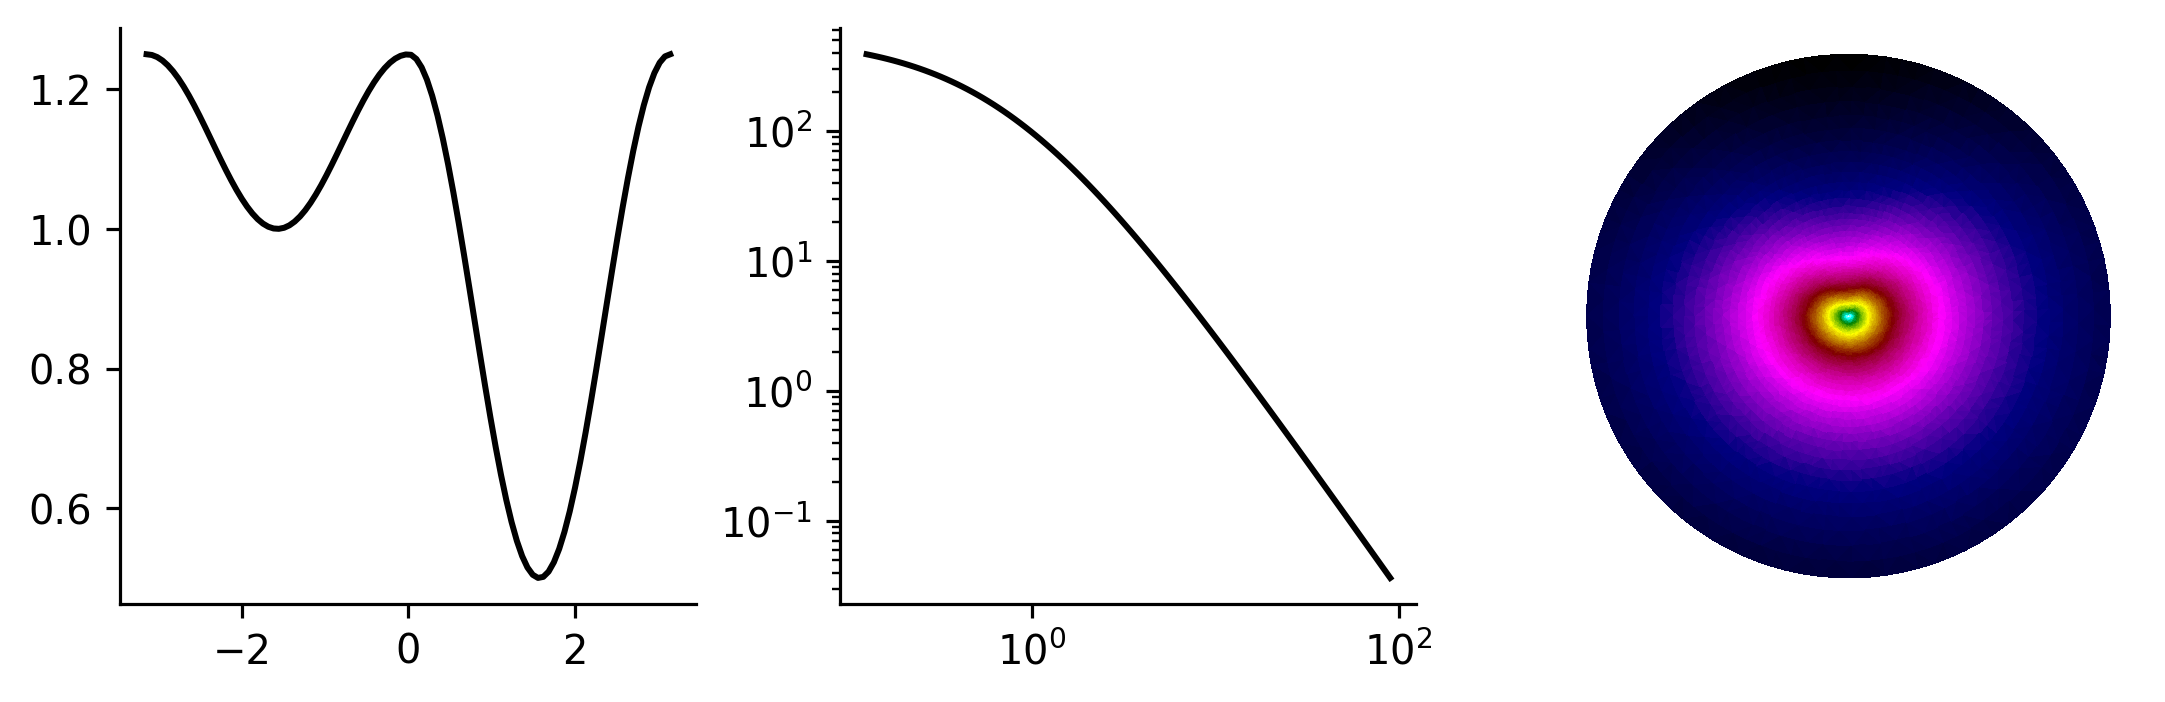

In [70]:
(fig, axs) = plt.subplots(1, 3, figsize=(7, 2), dpi=72*4)
fig.subplots_adjust(0,0,1,1,0.25,0)
for ax in axs:
    for sp in ['top','right']:
        ax.spines[sp].set_visible(False)

t = np.linspace(-np.pi, np.pi, 100)
mult = cmmdl_tan_multiplier(torch.tensor(t, dtype=torch.float), ui=0, li=0).detach().numpy()
axs[0].plot(t, mult, 'k-')

r = np.logspace(-3, np.log2(90.0), 100, base=2)
cm2 = cmmdl_hhcmag2(r)
axs[1].loglog(r, cm2, 'k-')

(r,t) = np.meshgrid(r, t)
(r,t) = (r.flatten(), t.flatten())
(x,y) = (r*np.cos(t), r*np.sin(t))
cm2 = cmmdl_cmag2(torch.tensor(t, dtype=torch.float),
                  torch.tensor(r, dtype=torch.float))
tri = mpl.tri.Triangulation(x, y)
axs[2].tripcolor(x, y, torch.log(cm2), cmap='log_eccentricity')
axs[2].axis('equal')
axs[2].axis('off')

pass

##### Calculation and Plan Code

In [71]:
@pimms.calc('gradients')
def init_gradients():
    '''
    Initializes an empty (mutable!) dictionary for tracking the elements of the
    model that are part of the gradient descent.
    '''
    return ({},)
@pimms.calc('cmag_eccen_offset_free', 'prfsize_gain_free')
def init_cmag_params(dtype, gradients,
                     prior_cmag_eccen_offset=(1.0, 0.75, 0.70, 0.65),
                     prior_prfsize_gain=(8.0, 5.0, 6.0, 7.0),
                     cmag_eccen_offset_lim=(0.01, 2.5),
                     prfsize_gain_lim=(0.05, 100.0),
                     cmag_grad=True,
                     prfsize_grad=True):
    '''
    Initializes the model parameters required to calculate the cortical
    magnification of each vertex and/or visual field position. This
    calculation initializes the "free" versions of the cmag_eccen_offset
    parameters--i.e., the version that can range from -inf to inf but that gets
    limited into a particular range for the actual model calculation.
    
    Afferent parameters:
     @ prior_cmag_eccen_offset The initial value of the offset parameter c2 
       from Horton and Hoyt's (1991) equation cmag(ecc) = c1 / (c2 + ecc).
       This should be a tensor of 4 values for visual areas (none, v1, v2, v3).
     @ cmag_eccen_offset_lim The (min, max) values that the cmag_eccen_offset
       parameter is allowed to take in the retinotopy model.
     @ prior_prfsize_gain The initial value of the gain parameter g that
       is divided by the cortical magnification in order to predict the pRF
       size for a visual area. This should be a tuple of 4 values for visual
       areas (none, v1, v2, v3).
     @ prfsize_gain_lim The (min, max) values that the prfsize_gain parameter
       is allowed to take in the retinotopy model.
       
    Efferent values:
     @ cmag_eccen_offset_free The free/unlimited version of the cortical
       magnification offset parameter. As a free parameter, the value may be
       any real number; the limited version is calculated using the CDF of the
       acrtangent function.
     @ prfsize_gain_free The free/unlimited version of the pRF size gain
       parameter. As a free parameter, the value may be any real number; the
    '''
    tups = [
        ('cmag_eccen_offset_free', cmag_eccen_offset_lim, prior_cmag_eccen_offset, cmag_grad),
        ('prfsize_gain_free',      prfsize_gain_lim,      prior_prfsize_gain,      prfsize_grad)]
    rval = {}
    for (k,(mn,mx),pri,grad) in tups:
        if len(pri) != 4:
            raise ValueError('prior for %s must be a length 4 tuple' % (k,))
        pri_free = unlimit_param(totensor(pri), mn, mx)
        #print(k, pri, mn, mx, pri_free)
        if pri_free.shape == ():
            pri_free = torch.ones(4, dtype=dtype)*pri_free
        u = torch.tensor(pri_free.detach().numpy(),
                         dtype=dtype,
                         requires_grad=grad)
        if grad: gradients[k] = u
        rval[k] = u
    return rval
@pimms.calc('cmag_eccen_offset', 'prfsize_gain')
def calc_cmag_params(cmag_eccen_offset_free,
                     prfsize_gain_free,
                     cmag_eccen_offset_lim,
                     prfsize_gain_lim):
    '''
    Calculates the model parameters required to calculate the cortical
    magnification of each vertex and/or visual field position. This
    calculation involves running the free versions of each pameter through the
    arctangent function in order to convert an infinite range to the range
    (0,1) then linearly expanding that to the parameter's limit.
    
    Efferent values:
     @ cmag_eccen_offset The range-limited translation of the
       cmag_eccen_offset_free parameter based on cmag_eccen_offset_lim. The
       eccentricity offset in the cortical magnification model is the value for
       the parameter c2 in Horton and Hoyt's (1991) cortical magnification
       equation: cmag(eccen) = (c1 / (c2 + eccen))^2.
       This parameter should be a 4-tensor of the parameters for the visual
       areas (none, v1, v2, v3).
     @ prfsize_gain The range-limited translation of the prfsize_gain_free
       parameter based on prfsize_gain_lim. The prfsize_gain together with
       the cortical magnification of a point in the visual field determines
       the predicted pRF size: prfsize = gain / sqrt(cmag).
       This parameter should be a 4-tensor of the parameters for the visual
       areas (none, v1, v2, v3).
    '''
    tups = [(cmag_eccen_offset_lim, cmag_eccen_offset_free),
            (prfsize_gain_lim,      prfsize_gain_free)]
    (eo,sg) = [limit_param(free, mn, mx) for ((mn,mx),free) in tups]
    return (eo, sg)
@pimms.calc('cmag_scale')
def calc_cmag_scale(eccen, varea_weights, cmag_eccen_offset,
                    max_stim_eccen, vertex_areas_mm2, dtype):
    '''
    Calculates the 'cmag_scale' meta-parameter for each visual area.
    
    Efferent values:
     @ cmag_scale The meta-parameter (c1) that can be calculated from the
       'cmag_eccen_offset' (c2) parameter and the total visual area size,
       based on the fact that the cortical magnification used in the model
       conforms to Horton and Hoyt's (1991) equation:
       cmag2(ecc) = (c1 / (c2 + ecc))^2.
       The calculation of cmag_scale uses the surface area of the region of
       each visual area that is within max_stim_eccen to calculate the
       parameter value.
    '''
    q = (eccen < max_stim_eccen)
    szs = [torch.sum(branch(q, vertex_areas_mm2*ws)) for ws in varea_weights]
    r = torch.zeros((len(varea_weights), len(eccen)), dtype=dtype)
    for (ii,(sz,c2)) in enumerate(zip(szs, cmag_eccen_offset)):
        r[ii] = cmmdl_c1(sz, max_stim_eccen, c2)
    return (r,)

In [72]:
cmag_plan = pimms.plan(
    {'init_gradients': init_gradients,
     'init_cmag_params': init_cmag_params,
     'calc_cmag_params': calc_cmag_params,
     'calc_cmag_scale': calc_cmag_scale})

#### PRF Size Model

##### Explanation

The pRF size is determined by offset and scale parameters $b_k$ and $\gamma_k$ for each visual area $k$. The pRF size $s$ is:

$$ s(\rho; b, \gamma) = b + \gamma \rho $$

There is good reason to think that pRF size should be inversely related to cortical magnification, with the product of the two equalling a constant in each visual area. The particular value of the constant must likely vary both with voxel size as well as visual area. For this reason, we can use the coefficients from the cortical magnification equation directly.

$$ s_k(\theta, \rho) = \frac{g_k}{\sqrt{m(\theta, \rho)}} $$

However, a major disruption in the pRF size is that the stimulus edge interacts with the pRF estimates. Any voxel whose true pRF overlaps with the stimulus edge is confusable with another voxel on the other side of the stimulus edge whose pRF also overlaps with a similar amount of the stimulus. This means that a few things can happen near the stimulus edge:

1. The measured pRF sizes can drop
2. The measured eccentricity can decrease

Both of these occur because the true pRF, under limited stimulus, can be modeled with a smaller less eccentric pRF. The effect can be modeled as follows, where $s$ is the true (predicted) pRF size, $\hat{s}$ is the prediction of the measured pRF size, and $\hat{\rho}$ is the prediction of the measured eccentricity. Both of these functions use the weights $w_k(\theta, \rho; \psi)$ where $\psi$ is the max stimulus eccentricity.

$$ w_k(\theta, \rho; \psi) = \frac{1}{2}\left( 1 - \hbox{erf}\left(\frac{\rho - (\psi - s_k(\theta, \psi)}{s_k(\theta, \psi)/2}\right) \right) $$

$$ \hat{s}_k(\theta, \rho) = \frac{1}{2} \left( \left[\rho + s_k(\theta, \rho)\right][1 - w_k(\theta, \rho; \psi)] + \psi \, w_k(\theta, \rho; \psi) - [\rho - s_k(\theta, \rho)] \right) $$

##### Core Functions

In [73]:
def rfmdl_prfsize(cmag2, gain):
    '''
    Yields the predicted true pRF size for the given cortical magnification
      predictions and the visual-area's gain.
    '''
    return gain / safesqrt(cmag2)
def rfmdl_stimweight(rho, prfsz, max_stim_eccen):
    '''
    Yields the stimulus weight at the given eccentricities (rho) for the
      given pRF size and max stimulus eccentricity.
    '''
    num = rho - (max_stim_eccen - prfsz)
    den = prfsz / 2
    return (1 - torch.erf(num / den)) / 2
def rfmdl_meas_prfsize(rho, prfsz, stimweight, max_stim_eccen):
    '''
    Yields the predicted measured pRF sizes for the given eccentricities,
      true pRF sizes, and the maximum stimulus eccentricity.
    '''
    w = stimweight
    t1 = rho + prfsz
    t2 = max_stim_eccen
    t3 = rho - prfsz
    return 0.5*(t1*w + t2*(1 - w) - t3)

##### Demo

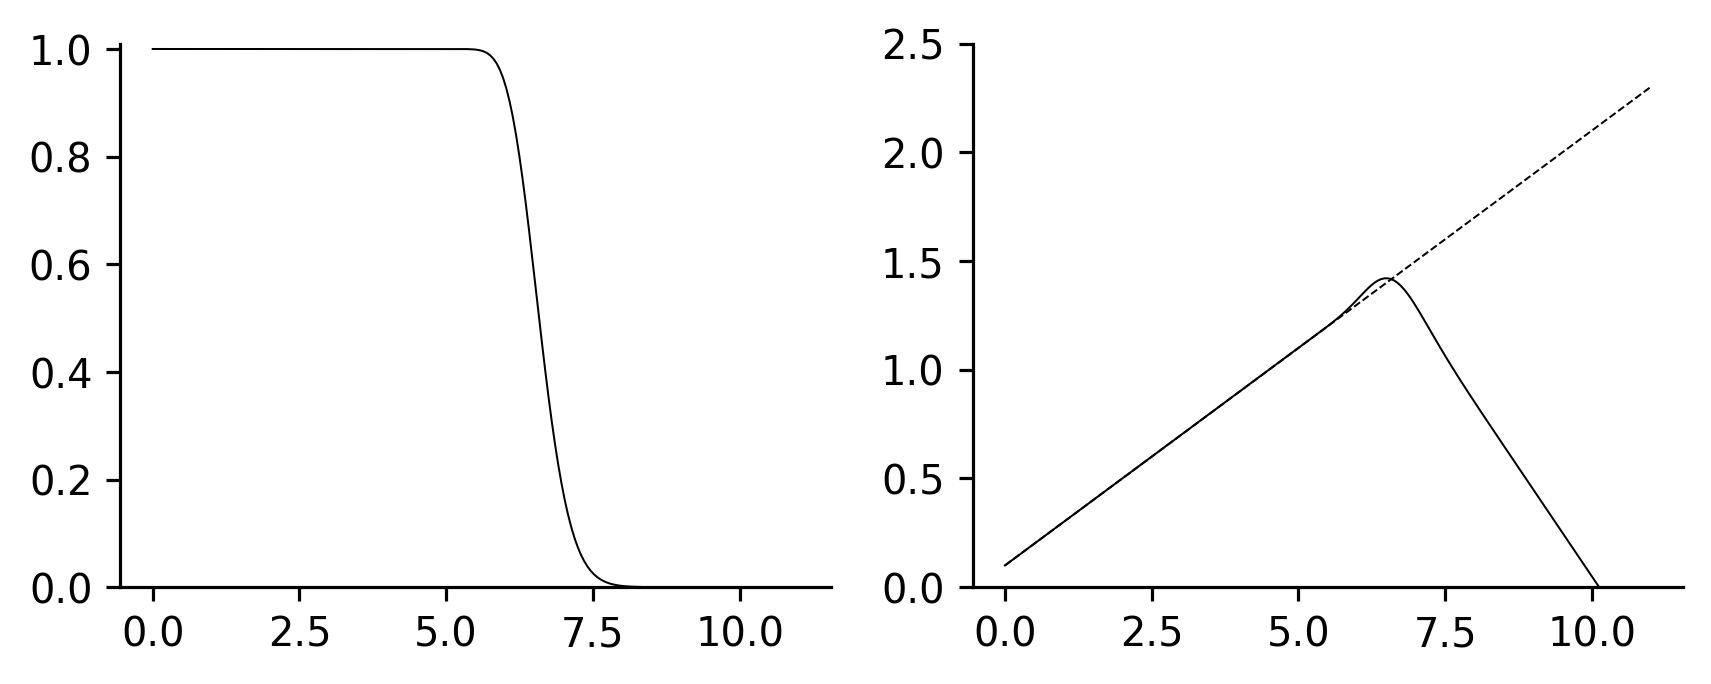

In [74]:
(fig,axs) = plt.subplots(1, 2, figsize=(7, 2.5), dpi=72*4)
#fig.subplots_adjust(0,0,1,1,0.25,0)
for ax in axs:
    for sp in ['top','right']:
        ax.spines[sp].set_visible(False)


rho = torch.tensor(np.linspace(0, 11, 200), dtype=torch.float)
# Simulate true pRF size for this rho value.
prfsz = 0.1 + rho*0.2

ax = axs[0]
w = rfmdl_stimweight(rho, prfsz, 8)
ax.plot(rho, w, 'k-', lw=0.5)
ax.set_ylim([0,1.01])

ax = axs[1]
ax.plot(rho, prfsz, 'k--', lw=0.5)
ax.plot(rho, rfmdl_meas_prfsize(rho, prfsz, w, 8), 'k-', lw=0.5)
ax.set_ylim([0,2.5])

pass

##### Calculation and Plan Code

In [75]:
@pimms.calc('zsign')
def calc_zsign(theta_spiral, eccen, faces):
    '''
    Calculates the z-sign value for each face in the model mesh.
    
    Efferent values:
     @ zsign The z-sign value of each face in the model mesh. The z-sign is
       conceptually similar to the field-sign but is calculated from the eccen
       and theta_spiral parameters instead of the true pRF centers, meaning that
       there should always only be a single sign of all the z-signs for all of
       V1-V3. The value calculated for triangle (a,b,c) is (b-a) x (c-a) / 2,
       which is the area of the triangle in the visual field times its
       fieldsign.
    '''
    (a,b,c) = faces
    tht = theta_spiral
    (x,y) = (eccen*torch.cos(tht), eccen*torch.sin(tht))
    (x_ab,y_ab) = (x[b] - x[a], y[b] - y[a])
    (x_ac,y_ac) = (x[c] - x[a], y[c] - y[a])
    z = (x_ab*y_ac - x_ac*y_ab) / 2
    return (z,)
@pimms.calc('areal_cmags', 'areal_vmag', 'prfsizes', 'prfsize',
            'mean_areal_vmag', 'face_areal_vmag')
def calc_cmag(theta_rescaled, theta, eccen, varea_weights, faces, zsign,
              cmag_eccen_offset, cmag_scale, face_areas_mm2,
              uvm_ipsilateral, lvm_ipsilateral, hva, vma,
              prfsize_gain, dtype):
    '''
    Calculates the model per-visual-area cortical magnification values and the
      model pRF size (i.e., the pRF size that the model believes to be the true
      pRF size, not the prediction of the measured pRF size, 'pref_prfsize').
      
    Efferent values:
     @ areal_cmags The cortical magnifications, in square mm per square degree,
       for each vertex and each visual area, as predicted by the retinotopy
       model. This is a 4 x n tensor where the rows correspond to the visual
       areas themselves (i.e., there is a prediction for each model).
     @ areal_vmag The predicted measured visual magnification, in square
       degrees per square mm, for each vertex. These values are collapsed
       across visual areas prior to being calculated, unlike areal_cmags.
     @ mean_areal_vmag The predicted measured visual magnification, in square
       degrees per square mm, for each face. These values are collapsed
       across visual areas prior to being calculated, unlike areal_cmags. The
       face vmags are formed by averaging the vmags of each face's corners.
     @ face_areal_vmag The areal visual magnification, in square degrees per
       squre mm, for each face, as calculated by the area of the triangle in
       the visual field divided by the surface area of the triangle on cortex.
       This value is negative if the fieldsign of the theta_spiral for the
       triangle is negative and positive otherwise.
     @ prfsizes The pRF sizes, in degrees, for each vertex and each visual
       area, as predicted by the retinotopy model. This is a 4 x n tensor where
       the rows correspond to the visual areas themselves (i.e., there is a
       prediction for each visual area).
     @ prfsize The pRF size, in degrees, for each vertex and each visual area,
       as predicted by the retinotopy model. This value is calculated using the
       weighted sum of the values in 'prfsizes' where the weights come from
       'varea_weights'.
    '''
    uis = uvm_ipsilateral
    lis = lvm_ipsilateral
    c1s = cmag_scale
    c2s = cmag_eccen_offset
    gs  = prfsize_gain
    iis = range(len(varea_weights))
    (uis, lis, c1s, c2s, hs, vs, gs) = [
        [u for _ in varea_weights] if np.shape(u) == () else u
        for u in (uis, lis, c1s, c2s, hva, vma, gs)]
    cmags = torch.zeros((len(varea_weights), len(eccen)), dtype=dtype)
    rfszs = torch.zeros((len(varea_weights), len(eccen)), dtype=dtype)
    for (ii, c1,c2, ui,li, h,v,g) in zip(iis, c1s,c2s, uis,lis, hs,vs,gs):
        cmags[ii] = cmmdl_cmag2(theta_rescaled, eccen,
                                c1=c1, c2=c2,
                                ui=ui, li=li,
                                hva=h, vma=v)
        rfszs[ii] = rfmdl_prfsize(cmags[ii], g)
    # calculate the vmag now...
    vmag = torch.sum(zinv(cmags) * varea_weights, axis=0)
    (a,b,c) = faces
    meanvmag = (vmag[a] + vmag[b] + vmag[c]) / 3.0
    # and the actual vmag from the coordinates
    facevmag = zsign / face_areas_mm2
    # and the predicted overall prfsize, using the visual area weights
    rfsz = torch.sum(rfszs * varea_weights, axis=0)
    # Finally, calculate the actual 
    return (cmags, vmag, rfszs, rfsz, meanvmag, facevmag)
@pimms.calc('stim_weight')
def calc_stim_weight(eccen, prfsize, max_stim_eccen):
    '''
    Calculates the stimulus weight given the eccentricity, prfsize, and maximum
    stimulus eccentricity.
    
    Efferent values:
     @ stim_weight The stimulus weight, roughly interpretable as the overlap
       with the stimulus, of each vertex.
    '''
    return (rfmdl_stimweight(eccen, prfsize, max_stim_eccen),)
@pimms.calc('pred_prfsize')
def calc_pred_prfsize(eccen, prfsize, stim_weight, max_stim_eccen):
    '''
    Calculates the predicted pRF size, i.e., the prediction of what the pRF
    size measurement would be, not the prediction of the true underlying
    prfsize.
    
    Efferent values:
     @ pred_prfsize The predicted measurement of pRF size associated with each
       vertex, according to the retinotopy model. This is different from the
       'prfsize' value in that 'prfsize' is the model's predicted true pRF size
       while 'pred_prfsize' is the model's prediction of the measured pRF size,
       based on biases associated with the stimulus edge.
    '''
    return (rfmdl_meas_prfsize(eccen, prfsize, stim_weight, max_stim_eccen),)

In [76]:
prfsize_plan = pimms.plan(
    {'calc_zsign': calc_zsign,
     'calc_cmag': calc_cmag,
     'calc_stim_weight': calc_stim_weight,
     'calc_pred_prfsize': calc_pred_prfsize})

#### PRF Center Model

##### Explanation

The predicted true pRF polar angle and eccentricity are determined by the angle-coefficient and eccentricity parameters, respectively. However, the predicted measured eccentricity differs from the predicted true eccentricity in that it depends on the pRF size and the maximum stimulus eccentricity. This dependence is similar to the pRF size's own dependence on the stimulus eccentricity. Essentially, the measured eccentricity will be at the center of the part of the pRF that is being measued by the stimulus.

$$ \hat{\rho}_k(\theta, \rho; \psi) = \frac{1}{2} \left( [\rho - s_k(\theta, \rho)] + \psi \, [1 - w_k(\theta, \rho; \psi)] + [\rho + s_k(\theta, \rho)]\,w_k(\theta, \rho; \psi) \right) $$

The measured polar angle prediction is given by `theta()` above.

##### Core Functions

In [77]:
def rfmdl_meas_eccen(rho, prfsz, stimweight, max_stim_eccen):
    '''
    Yields the predicted measured eccentricity for the given eccentricities,
      true pRF sizes, and the maximum stimulus eccentricity.
    '''
    w = stimweight
    t1 = rho + prfsz
    t2 = max_stim_eccen
    t3 = rho - prfsz
    return 0.5*(t1*w + t2*(1 - w) + t3)

##### Demo

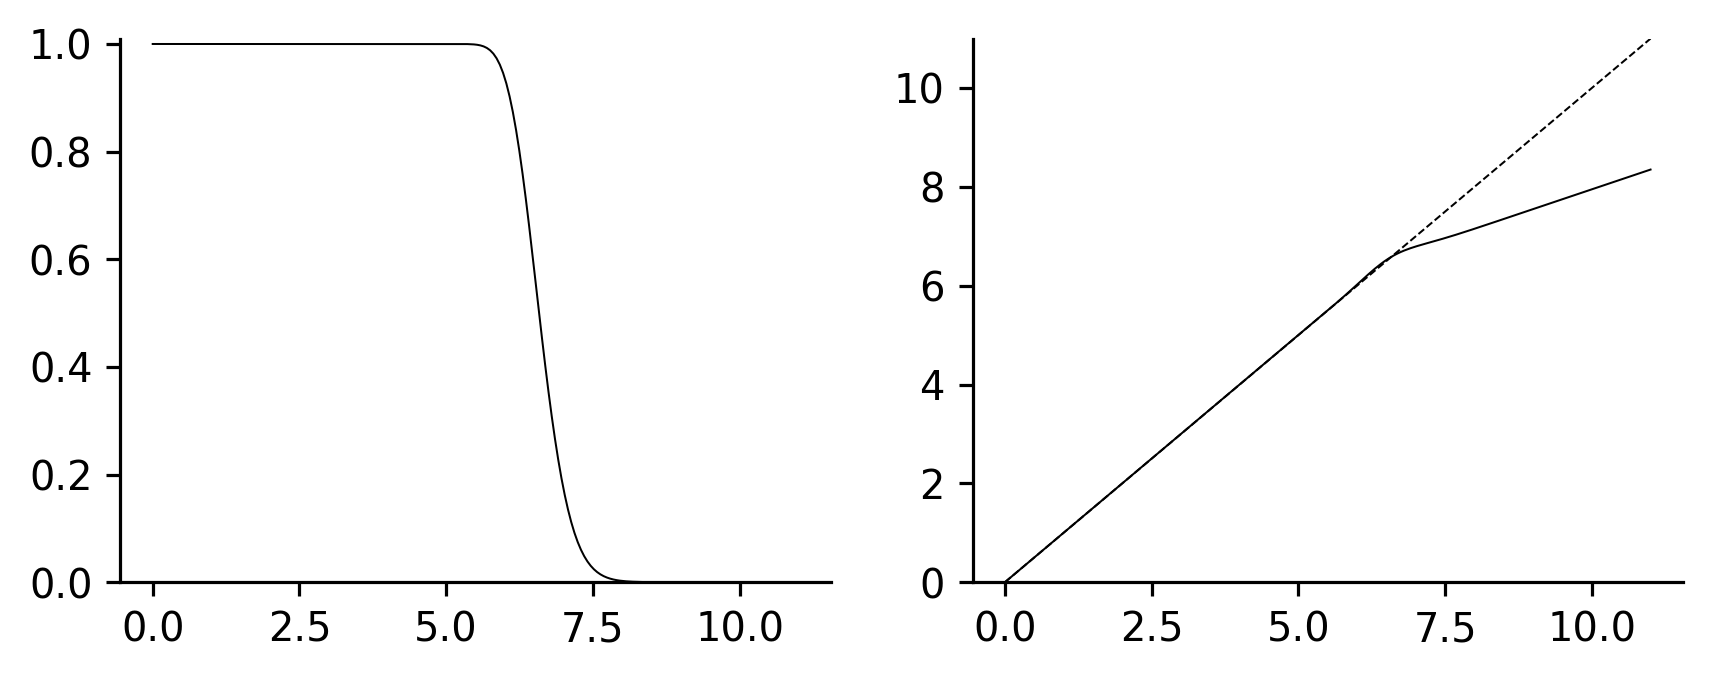

In [78]:
(fig,axs) = plt.subplots(1, 2, figsize=(7, 2.5), dpi=72*4)
#fig.subplots_adjust(0,0,1,1,0.25,0)
for ax in axs:
    for sp in ['top','right']:
        ax.spines[sp].set_visible(False)

rho = torch.tensor(np.linspace(0, 11, 200), dtype=torch.float)
# Simulate true pRF size for this rho value.
prfsz = 0.1 + rho*0.2

ax = axs[0]
w = rfmdl_stimweight(rho, prfsz, 8)
ax.plot(rho, w, 'k-', lw=0.5)
ax.set_ylim([0,1.01])

ax = axs[1]
ax.plot(rho, rho, 'k--', lw=0.5)
ax.plot(rho, rfmdl_meas_eccen(rho, prfsz, w, 8), 'k-', lw=0.5)
ax.set_ylim([0,11])

pass

##### Calculation and Plan Code

In [79]:
@pimms.calc('pred_eccen')
def calc_pred_eccen(eccen, prfsize, stim_weight, max_stim_eccen):
    '''
    Calculates the predicted eccentricity, which is based on both the true
    eccentricity ('eccen') and the stimulus.
    
    Efferent values:
     @ pred_eccen The predicted measurement of pRF eccentricity associated with
       each vertex, according to the retinotopy model. This is different from
       the 'eccen' value in that 'eccen' is the model's predicted true
       eccentricity while 'pred_eccen' is the model's prediction of the
       measured eccentricity.
    '''
    pe = rfmdl_meas_eccen(eccen, prfsize, stim_weight, max_stim_eccen)
    return {'pred_eccen': pe}

#### Variance Explained Model

##### Explanation

The variance explained by the model should be highest within a certain range of the stimulus. Given the `max_stim_eccen`, which is the maximum eccentricity of the stimulus, we can predict this range. Across the HCP subjects, variance explained $r$ is approximately equal to the following equation within the range of the stimulus, with $\omega$ indicating a gain that in the HCP data was approximately $0.55$:

$$ r^{(\hbox{stim})}(\rho; \omega) = \frac{\omega}{2} \left( 1 + \hbox{erf}(\rho - 0.8) / 0.4) \right) $$

Additionally, the variance explained will drop as eccentricity passes stimulus edge. As soon as the prediction of the measured pRF size drops to 0, the variance explained should also be 0, so we use the following:

$$ r^{(\hbox{peri})}_k(\theta, \rho; \psi, \omega) = \frac{\omega}{2} \left( 1 - \hbox{erf}((\rho - \psi) / s_k(\theta, \rho)) \right) $$

The overall variance explained model is just the product of these two:

$$ r_k(\theta, \rho; \psi, \omega) = \frac{r^{(stim)}(\rho; \omega) \, r^{(peri)}_k(\theta, \rho; \psi, \omega)}{\omega} $$

$$ r_k(\theta, \rho; \psi, \omega, \mu_r, \sigma_r) = \frac{\omega}{4} \, \left[ 1 + \hbox{erf}(\rho - \mu_r) / \sigma_r) \right] \, \left[ 1 - \hbox{erf}((\rho - \psi) / s_k(\theta, \rho)) \right] $$

Where $\mu_r$ and $\sigma_r$ are approximately $1$ and $1/2$, respectively, in the HCP dataset. These are referred to as `cod_eccen_mean` and `cod_eccen_std` in the code.

###### Core Functions

In [80]:
def r2mdl_stim_cod(rho, cod_eccen_mean=1.0, cod_eccen_std=0.5):
    '''
    Yields the stimulus variance explained value (r^(stim) in the above
      cell, without the omega multiplier).
    '''
    return (1 + torch.erf((rho - cod_eccen_mean) / cod_eccen_std)) / 2
def r2mdl_peri_cod(rho, prfsize, max_stim_eccen):
    '''
    Yields the peripheral variance explained value (r^(peri) in the above
      cell, without the omega multiplier).
    '''
    return (1 - torch.erf((rho - max_stim_eccen) / prfsize)) / 2
def r2mdl_meas_cod(rho, prfsize, max_stim_eccen,
                   omega=0.55, cod_eccen_mean=1.0, cod_eccen_std=0.5):
    '''
    Yields the predicted coefficient of determination of the measurement for
      the given eccentricity, prfsize, and maximum stimulus eccentricity.
    '''
    rstim = r2mdl_stim_cod(rho,
                           cod_eccen_mean=cod_eccen_mean,
                           cod_eccen_std=cod_eccen_std)
    rperi = r2mdl_peri_cod(rho, prfsize, max_stim_eccen)
    return omega * rstim * rperi

##### Demo

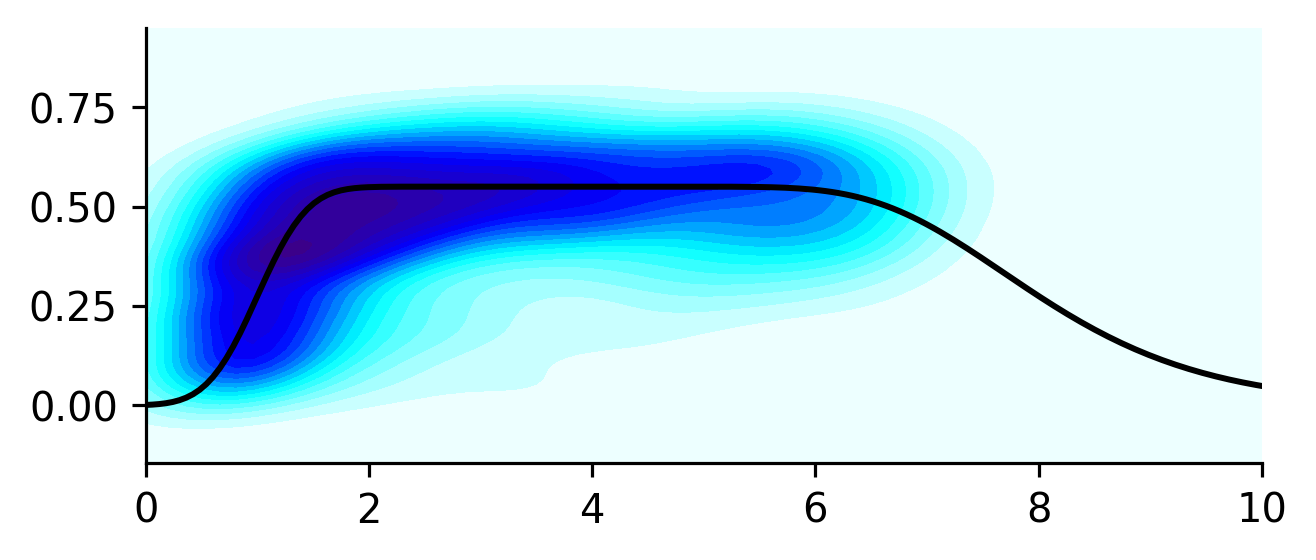

In [81]:
import seaborn as sns
import scipy as sp

(fig,ax) = plt.subplots(1,1, figsize=(5,2), dpi=72*4)
for s in ['top','right']:
    ax.spines[s].set_visible(False)

# Plot density of vexpl in terms of eccen:
df = data.dataframe
df = df.loc[df['visual_area'] == 1]
x = df['clean_eccentricity'].values
y = df['prf_variance_explained'].values
ii = np.where(np.isfinite(x) & np.isfinite(y))[0]
# Randomly select a subset of these:
ii = np.random.choice(ii, 2000, replace=False)
sns.kdeplot(x[ii], y[ii], ax=ax, shade=True, cmap='bluish',
            levels=20)
# Plot the predicted vexpl line. Note that the density
# plot doesn't include any values above 7.
x = torch.tensor(np.linspace(0,12,200), dtype=torch.float)
y = r2mdl_meas_cod(x, 0.1+0.2*x, 8)
ax.plot(x, y, 'k-')
ax.set_xlim([0,10])

pass

##### Calculation and Plan Code

In [82]:
@pimms.calc('cod_omega_free', 'cod_eccen_mean_free', 'cod_eccen_std_free')
def init_cod_params(dtype, gradients,
                    prior_cod_omega=(0.0, 0.55, 0.50, 0.45),
                    prior_cod_eccen_mean=1.0,
                    prior_cod_eccen_std=0.5,
                    cod_omega_lim=(0.01, 1.0),
                    cod_eccen_mean_lim=(0.1, 2.5),
                    cod_eccen_std_lim=(0.05, 1.25),
                    cod_grad=True):
    '''
    Initializes the model parameters required to calculate the coefficient of
    determination (variance explained) of each vertex and/or visual field
    position. This calculation initializes the "free" versions of the
    cod_omega, cod_eccen_mean, and cod_eccen_std parameters--i.e., the version
    that can range from -inf to inf but that gets limited into a particular
    range for the actual model calculation.
    
    Afferent parameters:
     @ prior_cod_omega The initial value of the omega parameter used in the
       coefficient of determination estimation. The omega value for a visual
       area is the maximum predicted variance-explained fraction for that
       visual area. This should be a tensor of 4 values for visual areas
       (none, v1, v2, v3).
     @ cod_omega_lim The (min, max) values that the cod_omega parameter is
       allowed to take in the retinotopy model.
     @ prior_cod_eccen_mean The initial value of the "eccentricity of mean COD"
       parameter. This parameter determines the point at which the COD has
       reached its half-max value in terms of eccentricity. This should be a
       tensor of 4 values for visual areas (none, v1, v2, v3) or a single value
       if they share a parameter.
     @ cod_eccen_mean_lim The (min, max) values that the cod_eccen_mean
       parameter is allowed to take in the retinotopy model.
     @ prior_cod_eccen_std The initial value of the "standard deviation of
       initial COD by eccentricity" parameter. This parameter determines the
       speed at which the predicted COD rises from the fovea. This should be a
       tuple of 4 values for visual areas (none, v1, v2, v3) or a single value
       if they share a parameter.
     @ cod_eccen_std_lim The (min, max) values that the cod_eccen_std
       parameter is allowed to take in the retinotopy model.
     @ cod_grad Whether the parameters involved in the COD calculation should
       be marked as part of the gradient.
       
    Efferent values:
     @ cod_omega_free The free/unlimited version of the COD omega, i.e., the
       maximum value the COD can take on. As a free parameter, the value may be
       any real number; the limited version is calculated using the acrtangent
       function.
     @ cod_eccen_mean_free The free/unlimited version of the "eccentricity of
       mean COD" parameter, i.e., the eccentricity at which the CDF first
       reaches its mean value. As a free parameter, the value may be any real
       number; the limited version is calculated using the acrtangent function.
     @ cod_eccen_std_free The free/unlimited version of the COD model parameter
       that determines the speed at which the COD reaches its max value in
       terms of eccentricity. As a free parameter, the value may be any real
       number; the limited version is calculated using the acrtangent function.   
    '''
    import torch
    tups = [
        ('cod_omega_free',      cod_omega_lim,      prior_cod_omega),
        ('cod_eccen_mean_free', cod_eccen_mean_lim, prior_cod_eccen_mean),
        ('cod_eccen_std_free',  cod_eccen_std_lim,  prior_cod_eccen_std)]
    rval = {}
    for (k,(mn,mx),pri) in tups:
        if np.shape(pri) == ():
            pri = (pri, pri, pri, pri)
        if len(pri) != 4:
            raise ValueError('prior for %s must be a length 4 tuple' % (k,))
        pri_free = unlimit_param(totensor(pri), mn, mx)
        if pri_free.shape == ():
            pri_free = torch.ones(4, dtype=dtype)*pri_free
        u = torch.tensor(pri_free.detach().numpy(),
                         dtype=dtype,
                         requires_grad=cod_grad)
        if cod_grad: gradients[k] = u
        rval[k] = u
    return rval
@pimms.calc('cod_omega', 'cod_eccen_mean', 'cod_eccen_std')
def calc_cod_params(cod_omega_free, cod_eccen_mean_free, cod_eccen_std_free,
                    cod_omega_lim,  cod_eccen_mean_lim,  cod_eccen_std_lim):
    '''
    Calculates the model parameters required to calculate the predicted 
    coefficient of determination of each vertex and/or visual field position.
    This calculation involves running the free versions of each pameter through
    the arctangent function in order to convert an infinite range to the range
    (0,1) then linearly expanding that to the parameter's limit.
    
    Efferent values:
     @ cod_omega The range-limited translation of the cod_omega_free
       parameter based on cod_omega_lim. The omega value for a visual
       area is the maximum predicted variance-explained fraction for that
       visual area. This parameter should be a 4-tensor of the parameters
       for the visual areas (none, v1, v2, v3).
     @ cod_eccen_mean The range-limited translation of the cod_eccen_mean_free
       parameter based on cod_eccen_mean_lim. This parameter determines the
       point at which the COD has reached its half-max value in terms of
       eccentricity. This should be a tensor of 4 values for visual areas
       (none, v1, v2, v3).
     @ cod_eccen_std The range-limited translation of the cod_eccen_std_free
       parameter based on cod_eccen_std_lim. This parameter determines the
       speed at which the predicted COD rises from the fovea. This should be a
       tuple of 4 values for visual areas (none, v1, v2, v3).
    '''
    tups = [(cod_omega_lim, cod_omega_free),
            (cod_eccen_mean_lim, cod_eccen_mean_free),
            (cod_eccen_std_lim, cod_eccen_std_free)]
    vals = [limit_param(free, mn, mx) for ((mn,mx),free) in tups]
    return tuple(vals)
@pimms.calc('pred_cod')
def calc_pred_cod(eccen, prfsizes, max_stim_eccen, dtype,
                  cod_omega, cod_eccen_mean, cod_eccen_std,
                  varea_weights):
    '''
    Calculates the COD or variance explained that is predicted to be measured
    by the retinotopy model.
    
    Efferent values:
     @ pred_cod The predicted coefficient of determination or variance
       explained value for each vertex.
    '''
    p = torch.zeros(eccen.shape, dtype=dtype)
    # Anything in varea 0 has a cod of 0, so skip the first one:
    for (prfsize,om,mu,sig,wgt) in zip(prfsizes[1:], cod_omega[1:],
                                       cod_eccen_mean[1:], cod_eccen_std[1:],
                                       varea_weights[1:]):
        cod = r2mdl_meas_cod(eccen, prfsize, max_stim_eccen,
                             omega=om, cod_eccen_mean=mu, cod_eccen_std=sig)
        p += cod * wgt
    return (p,)

In [83]:
cod_plan = pimms.plan(
    {'init_cod_params': init_cod_params,
     'calc_cod_params': calc_cod_params,
     'calc_pred_cod': calc_pred_cod})

#### Likelihood Estimation

In [84]:
@pimms.calc('zsign_inner_width_free', 'zsign_outer_width_free')
def init_zsign_params(dtype, device, gradients,
                      zsign_grad=False,
                      prior_zsign_inner_width=0.25,
                      zsign_inner_width_lim=(0.004,250.0),
                      prior_zsign_outer_width=0.25,
                      zsign_outer_width_lim=(0.004,250.0)):
    '''
    Initializes the z-sign parameters.
    
    Afferent parameters:
     @ prior_zsign_inner_width The prior value of the z-sign's inner width
       parameter. See zsign_inner_width for more information.
     @ zsign_inner_width_lim The (min, max) value that the z-sign's inner width
       can take during optimization.
     @ prior_zsign_outer_width The prior value of the z-sign's outer width
       parameter. See zsign_outer_width for more information.
     @ zsign_outer_width_lim The (min, max) value that the z-sign's outer width
       can take during optimization.

    Efferent values:
     @ zsign_outer_width_free The free (unlimited) value of the z-sign outer
       width parameter. See zsign_outer_width for more information.
     @ zsign_inner_width_free The free (unlimited) value of the z-sign inner
       width parameter. See zsign_inner_width for more information.
    '''
    zout = totensor(prior_zsign_outer_width,
                    dtype=dtype, requires_grad=zsign_grad)
    zinn = totensor(prior_zsign_inner_width,
                    dtype=dtype, requires_grad=zsign_grad)
    # We convert to log in order to prevent the unlimit_param and limit_param
    # steps from having a bias--the values will have trouble approaching the
    # ends of the range, and since the inner and outer widths are coefficients,
    # being infinitesimally close to 0 should be just as hard as being
    # infinitely close to infinity (but not harder).
    (mni,mxi) = [torch.log(totensor(u, dtype=dtype))
                 for u in zsign_inner_width_lim]
    (mno,mxo) = [torch.log(totensor(u, dtype=dtype))
                 for u in zsign_outer_width_lim]
    zinn = torch.log(zinn)
    zout = torch.log(zout)
    zinn = unlimit_param(zinn, mni, mxi).to(device)
    zout = unlimit_param(zout, mno, mxo).to(device)
    if zsign_grad:
        gradients['zsign_inner_width_free'] = zinn
        gradients['zsign_outer_width_free'] = zout
    return (zinn,zout)
@pimms.calc('zsign_inner_width', 'zsign_outer_width')
def prep_zsign_params(zsign_inner_width_lim, zsign_inner_width_free,
                      zsign_outer_width_lim, zsign_outer_width_free,
                      dtype):
    '''
    Prepares the zsign inner and outer width parameter values from the
    zsign_inner_width_free and zsign_outer_width_free unlimted parameters.
    The limiting is performed by using the arctan function and linearly
    expanding to the parameter range.
    
    Efferent values:
     @ zsign_inner_width The width of the inner (exponential) part of the zsign
       Gumbel distribution. For more information about the distribution see
       help(calc_zsign_likelihood).
     @ zsign_outer_width The width of the outer (linear) part of the zsign
       Gumbel distribution. For more information about the distribution see
       help(calc_zsign_likelihood).
    '''
    (mni,mxi) = [torch.log(totensor(u, dtype=dtype))
                 for u in zsign_inner_width_lim]
    (mno,mxo) = [torch.log(totensor(u, dtype=dtype))
                 for u in zsign_outer_width_lim]
    zinn = limit_param(zsign_inner_width_free, mni, mxi)
    zout = limit_param(zsign_outer_width_free, mno, mxo)
    zinn = torch.exp(zinn)
    zout = torch.exp(zout)
    return (zinn,zout)
@pimms.calc('zsign_likelihoods', 'zsign_likelihood')
def calc_zsign_likelihood(mean_areal_vmag, varea_weights, faces, anglecoef,
                          zsign_inner_width, zsign_outer_width, eccen,
                          face_areal_vmag, 
                          zsign_true=-1):
    '''
    Calculates the likelihood of the z-sign component of the retinotopy model.
    The z-sign is conceptually similar to the fieldsign but is not calculated
    using the visual x and y coordinates but rather the theta_spiral values;
    this means that although the magnitude of each face's zsign is equal to its
    cortical magnification, its sign is equal to its fieldsign (accepting that
    the fieldsign of V1, V2, and V3 will all be the same since the theta_spiral
    angles do not reverse).
    
    The likelihood of the zsigns are computed using a modified Gumbel
    distribution in which the exponential and linear portions of the PDF's
    exponent can be widened separately. The formula for this distribution is:
    
    PDF(x; mode, wi, wo) = s(wi,wo) exp(-[Fi(x;mode,wi,wo) + Fo(x;mode,wi,wo)])
      where:
        s(wi, wo) = 1/(wi gamma(wi/wo))
        Fi(x; mode, wi, wo) = exp(-[x - x0(mode, wi, wo)] / wi)
        Fo(x; mode, wi, wo) = [x - x0(mode, wi, wo)] / wo
        x0(mode, wi, wo) = mode - wi log(wo/wi)
    
    Afferent parameters:
     @ zsign_true The true zsign of the faces in the map relative to the 
       eccentricity (eccen) and anglecoef of each vertex. Should always be
       either 1 or -1.
    
    Efferent values:
     @ zsign_likelihoods The log-likelihood score of the z-sign values. Unlike
       the 'zsign_likelihood' value (notice the missing final s), the
       'zsign_likelihoods' has not been collapsed across faces. Instead, it is
       a tensor of the likelihood of each face.
     @ zsign_likelihood The sum of the log-likelihood score of the z-sign
       values.
    '''
    (a,b,c) = faces
    if zsign_true == -1: face_areal_vmag = -face_areal_vmag
    #z = face_areal_vmag / mean_areal_vmag
    #s = gumbel_log_prob(z, zsign_inner_width, zsign_outer_width, 1)
    #(ac_a, ac_b, ac_c) = [anglecoef[u] for u in faces]
    #acvar = (ac_a**2 + ac_b**2 + ac_c**2 - ac_a*ac_b - ac_a*ac_c - ac_b*ac_c)/3
    eccen = ((3.25 + eccen[a] + eccen[b] + eccen[c]) / 3)**2
    #width = zsign_inner_width * mean_areal_vmag * varweight
    width = zsign_inner_width * eccen
    z = (mean_areal_vmag - face_areal_vmag) / width
    #z[acvar > 0.9] = 0
    z = normal_log_prob(z)
    v123 = (1 - varea_weights[0]) > 0.5
    face_v123 = (v123[a] * v123[b] * v123[c])
    s = z * face_v123
    return (s, torch.sum(s))
@pimms.calc('zsign_weight')
def calc_zsign_weight(knob=0):
    '''
    Calculates the weight applied to the zsign component of the likelihood
    estimation used in the optimization. This weight is based on the knob
    parameter, and the actual weight used is 2^knob. The weight is multiplied
    by the zsign likelihood.
    
    Afferent parameters:
     @ knob The log of the relative weight to give to the zsign component of
       the likelihood calculation versus the measurement component. When the
       knob is positive, the zsign (cortical magnification optimization) is
       given a higher weight, and when the knob is negative, the measurement
       component is given a higher weight. Every 1 unit added to the knob
       doubles the weight on the zsign component and every 1 unit subtracted
       doubles the relative weight on the measurement component.
       
    Efferent values:
     @ zsign_weight The weight of the zsign component in the optimization;
       higher values indicate more weight given to the zsign while lower values
       indicate more weight given to the measurement component.
    '''
    return 0.0 if knob is None else (2.0**knob,)
def cod_log_prob(cod1, cod2):
    '''
    cod_log_prob(x, y) yields -x*(x - y)**2 - c where the constant c is equal
      to log(0.92787075845409).
    '''
    const = cod_log_prob.log_c_const
    cod_lp = -cod1*(cod1 - cod2)**2 - const
    return cod_lp
cod_log_prob.log_c_const = np.log(0.92787075845409)
@pimms.calc('meas_likelihoods', 'meas_likelihood', 'meas_likelihoods_parts')
def calc_meas_likelihood(pred_theta, meas_theta, pred_eccen, meas_eccen, eccen,
                         pred_prfsize, meas_prfsize, pred_cod, meas_cod,
                         meas_x, meas_y, mesh, varea_weights,
                         outside_penalty=0.0):
    '''
    Calculates the likelihood of the measurement component of the retinotopy
    model. The measurements component sums the likelihood of each vertex's
    measurements given the model predictions.
    
    The likelihood of the measurements are computed using a half-Cauchy
    distribution, which has long tails. The width of the distribution is
    inversely proportional to the predicted variance explained--i.e., having a
    lower variance explained value indicates a wider acceptance of predicted
    values.
    
    The likelihood of the pRF center is calculated using the half-Cauchy of the
    distance between the predicted and measured centers. The width of the
    distribution is proportional to both the inverse of the variance explained
    and to the predicted true eccentricity.
    
    The likelihood of the pRF size is calculated using the Cauchy distribution
    of the difference between the predicted and measured pRF size divided by
    the predicted eccentricity.
    
    The likelihood of the variance explained is given the probability
    distribution PDF(v0,v) = exp(v*(v0 - v)^2) / c where v0 is the measured
    variance explained and v is the predicted variance explained; c is the
    constant 0.92787075845409, determined by numerical integration, which is
    forces the volume of the above PDF to be 1. The likelihood associated with
    this distribution is -v*(v0-v)^2 - log(c).
    
    Afferent parameters:
     @ outside_penalty The penalty applied to vertices that are not in V1-V3
       in the model. This is balanced against the fact that the potential
       functions are not applied to vertices outside of V1-V3 in order to make
       it possible to extend boundaries into the outside and vice versa.
    
    Efferent values:
     @ meas_likelihoods The log-likelihood score of the measurement component
       of the optimization problem. Unlike the 'meas_likelihood' value (notice
       the missing final s), the 'meas_likelihoods' has not been collapsed
       across faces. Instead, it is a tensor of the likelihood of each face.
     @ meas_likelihood The sum of the log-likelihoods of the measurement
       component of the mesh vertices.
     @ meas_likelihoods_parts A persistent dictionary whose keys are 'center',
       'size', and 'cod' and whose values are the log-likelihood estimates of
       the PRF center, PRF size, and PRF variance explained components of the
       meas_likelihoods vector.
    '''
    pred_x = torch.cos(pred_theta) * pred_eccen
    pred_y = torch.sin(pred_theta) * pred_eccen
    meas_x = meas_x[mesh.labels]
    meas_y = meas_y[mesh.labels]
    meas_prfsize = meas_prfsize[mesh.labels]
    meas_cod = meas_cod[mesh.labels]
    # When dividing by eccentricity, to scale things such that a small error
    # in the fovea isn't undercounted relative to a large error in the
    # periphery, we don't want to risk dividing by 0, so we take a cue from
    # Horton and Hoyt and use 0.75 + eccen.
    eccen_den = (0.75 + eccen)
    # The width we use for scaled/ratio likelihood values:
    width = 0.25 * eccen_den / (1e-6 + pred_cod)
    # We want to limit this to v1-v3
    v123 = (1 - varea_weights[0]) > 0.5
    # The PRF center part:
    dist = torch.sqrt((pred_x - meas_x)**2 + (pred_y - meas_y)**2)
    center_lp = v123 * hcauchy_log_prob(dist / width)
    # The PRF size part:
    prfsize_lp = v123 * cauchy_log_prob((meas_prfsize - pred_prfsize) / width)
    # The COD part:
    cod_lp = v123 * cod_log_prob(pred_cod, meas_cod)
    # Finally, the outside part (there is a constant penalty for being
    # unexplained by the model--otherwise it is impossible to push the
    # boundary of V1-V3 outward).
    out_lp = -varea_weights[0] * outside_penalty
    # Add them together:
    llhoods = center_lp + prfsize_lp + cod_lp + out_lp
    # and return them!
    import pyrsistent as pyr
    parts = {'center': center_lp, 'size': prfsize_lp, 'cod': cod_lp,
             'outside': out_lp, 'width':width}
    return (llhoods, torch.sum(llhoods), pyr.pmap(parts))
@pimms.calc('likelihood')
def calc_likelihood(zsign_weight, zsign_likelihood, meas_likelihood):
    '''
    Calculates the likelihood estimate of the retinotopy model.
    
    See also calc_meas_likelihood and calc_zsign_likelihood.
    
    Efferent values:
     @ likelihood The likelihood estimate of the measurements and the 
       cortical magnification and fieldsign given the retinotopy model.
       This value is zsign_weight*zsign_likelihood + meas_likelihood.
    '''
    val = zsign_weight*zsign_likelihood + meas_likelihood
    return (val,)

In [85]:
likelihood_plan = pimms.plan(
    {'init_sign_params': init_zsign_params,
     'prep_zsign_params': prep_zsign_params,
     'calc_zsign_likelihood': calc_zsign_likelihood,
     'calc_zsign_weight': calc_zsign_weight,
     'calc_meas_likelihood': calc_meas_likelihood,
     'calc_likelihood': calc_likelihood})

#### Model Initialization and Preprocessing

##### Utility Functions

In [86]:
def imap_forget(imap, ks):
    '''
    imap_forget(imap, k) yields imap after clearing the cacne for key k. This
      can also be accomplished with: del imap[k].
    imap_forget(imap, [k1, k2, ...]) clears the cache for all the given keys.
    '''
    if pimms.is_str(ks): ks = [ks]
    for k in ks:
        del imap[k]
    return imap
def imap_efferents(imap, ks):
    '''
    imap_efferents(imap, k) yields the key names of any efferent of the key k
      in imap.
    imap_efferents(imap, [k1, k2, ...]) yields the key names of the any
      efferent of any of the given keys.
    '''
    if pimms.is_str(ks): ks = [ks]
    effs = set([])
    for (k,deps) in imap.plan.dependencies.items():
        if k in ks: continue
        for d in deps:
            if d in ks:
                effs.add(k)
                break
    return list(effs)

In [87]:
def gradplot(imap, dpi=72*4, figsize=(7,7.0*2/5), vmin=-5, vmax=5):
    fmap = imap['flatmap']
    (fig,axs) = plt.subplots(2, 5, figsize=figsize, dpi=dpi)
    fig.subplots_adjust(0,0,1,1,0,0)

    ang = imap['meas_theta'].detach().numpy()[fmap.labels]
    ang = np.mod(90 - 180/np.pi*ang + 180, 360) - 180
    ny.cortex_plot(fmap, color=ang, cmap='polar_angle',
                   vmin=-180, vmax=180, axes=axs[0,0])
    x = imap['meas_eccen'].detach().numpy()[fmap.labels]
    ny.cortex_plot(fmap, color=x, cmap='eccentricity',
                   vmin=0, vmax=90, axes=axs[1,0])

    ang = imap['pred_theta'].detach().numpy()
    ang = np.mod(90 - 180/np.pi*ang + 180, 360) - 180
    ny.cortex_plot(fmap, color=ang, cmap='polar_angle',
                   vmin=-180, vmax=180, axes=axs[0,1])
    x = imap['pred_eccen'].detach().numpy()
    ny.cortex_plot(fmap, color=x, cmap='eccentricity',
                   vmin=0, vmax=90, axes=axs[1,1])

    
    grads = imap['gradients']
    effs = imap_efferents(imap, grads.keys())
    for (k,axii) in zip(['likelihood','meas_likelihood','zsign_likelihood'],
                        [2,3,4]):
        imap_forget(imap, effs)
        for v in grads.values(): 
            if v.grad is not None:
                v.grad.fill_(0.0)
        (-imap[k]).backward()
        x = imap['anglecoef'].grad.detach().numpy()
        ny.cortex_plot(fmap, color=x, cmap='temperature_dark',
                       vmin=vmin, vmax=vmax, axes=axs[0,axii])
        x = imap['eccen'].grad.detach().numpy()
        ny.cortex_plot(fmap, color=x, cmap='temperature_dark',
                       vmin=vmin, vmax=vmax, axes=axs[1,axii])

    for ax in axs.flatten():
        ax.set_xlim([-30,80])
        ax.set_ylim([-50,60])
        ax.axis('off')
        
    return fig

##### Running the Model

In [88]:
makeplan = lambda: pimms.plan(
    init_subject_plan,
    anglecoef_plan,
    cmag_plan,
    prfsize_plan,
    cod_plan,
    likelihood_plan,
    calc_pred_eccen=calc_pred_eccen)

if 'prior' not in locals() or 'flatmap' not in locals():
    retinotopy_model_plan = makeplan()
    p = retinotopy_model_plan(sid=111312, hemi='lh',
                              max_stim_eccen=8, gradient={})
    prior = ny.vision.predict_retinotopy(p['cortex'])
    flatmap = p['flatmap']

# Aggregate all of the plans into a single plan!
retinotopy_model_plan = makeplan()

## Workspace

In [47]:
steps = 500
lr = 0.01
lr_decay = 0.0025

imap = retinotopy_model_plan(
    sid=111312, hemi='lh',
    max_stim_eccen=8,
    prior=prior,
    outer_penalty=20.0,
    precalc_flatmap=flatmap,
    prior_zsign_inner_width=0.05,
    prior_zsign_outer_width=2.0,
    zsign_true=-1,
    knob=0)

Starting...


<ipython-input-33-58b32f68aa93>:18: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  (x_ab,y_ab) = (x[b] - x[a], y[b] - y[a])


    0.00% :  37015.99609375
   20.00% :  35229.234375
   40.00% :  34978.8125
   60.00% :  34850.8828125
   80.00% :  34769.8828125
  100.00% :  34715.1171875


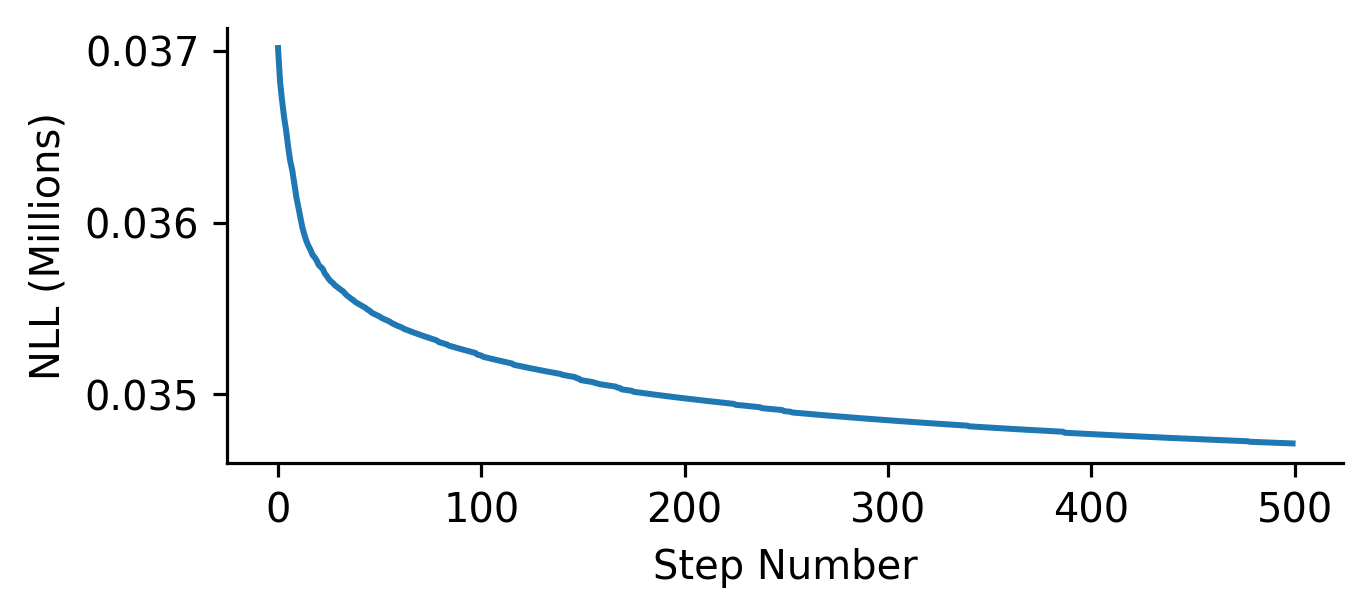

In [48]:
steps = 500
lr = 0.01
lr_decay = 0.0025

imap = retinotopy_model_plan(
    sid=111312, hemi='lh',
    max_stim_eccen=8,
    prior=prior,
    outer_penalty=20.0,
    precalc_flatmap=flatmap,
    prior_zsign_inner_width=0.05,
    prior_zsign_outer_width=2.0,
    zsign_true=-1,
    knob=0)

ac0 = imap['anglecoef']
ac0np = np.array(ac0.detach().numpy())
lbl0 = imap['pred_label']
lbl0np = np.array(lbl0.detach().numpy())

print("Starting...")
nll0 = -imap['likelihood']
eccen0 = np.array(imap['eccen'].detach().numpy())
print("  %6.2f%%" % 0.0, ": ", float(nll0))

gradients = imap['gradients']
grad_effs = imap_efferents(imap, gradients.keys())
gradients0 = {k:np.array(v.detach().numpy())
              for (k,v) in gradients.items()}

opt = torch.optim.Adagrad(list(gradients.values()), lr=lr, lr_decay=lr_decay)
#opt = torch.optim.SGD(list(gradients.values()), lr=lr, momentum=0.9, dampening=0.1)
tracking = []
for step in range(steps):
    def closure():
        opt.zero_grad()
        imap_forget(imap, grad_effs)
        nll = -imap['likelihood']
        if tracking is not None: tracking.append(float(nll))
        nll.backward()
        if step % 100 == 99:
            pct = (step + 1) * 100 / steps
            print("  %6.2f%%" % pct, ": ", float(nll))
        return nll
    opt.step(closure)
    
(fig,ax) = plt.subplots(1,1, figsize=(5,2), dpi=72*4)
ax.plot(np.array(tracking) / 1000000.0)
ax.set_xlabel('Step Number')
ax.set_ylabel('NLL (Millions)')
for s in ['top','right']: ax.spines[s].set_visible(False)

pass

In [ ]:
mag = 1
gradplot(imap, vmin=-mag, vmax=mag);

### Scratch

In [144]:
sid = 111312
hemi = 'lh'
q = init_subject_plan(sid=sid, hemi=hemi)
prior = ny.vision.predict_retinotopy(q['cortex'])
flatmap = q['flatmap']

In [734]:
x = torch.tensor(np.array(vis_x0.detach()), requires_grad=True)
y = torch.tensor(np.array(vis_y0.detach()), requires_grad=True)
q = unlimit_params(torch.tensor([15.3, 0.75, 0.5, 0.5, 0.09, 0.17]))
q = torch.tensor(q.detach().numpy(), requires_grad=True)
def paramdict():
    return {'x': np.array(x.detach().numpy()),
            'y': np.array(y.detach().numpy()),
            'q': np.array(limit_params(q).detach().numpy())}

# Store the initial parameters.
start_params = final_params = paramdict()
opt = None
def closure(zero=True):
    if zero: opt.zero_grad()
    s = limit_params(q)
    loss = cmag_potential(x, y, s) + 0.01*meas_potential(x, y) + smooth_potential(x, y)
    if zero: loss.backward()
    return loss
param_record = []
doSGD = False
for rr in range(3):
    opt = torch.optim.LBFGS([x, y], lr=0.1/np.exp(rr))
    print("Round: %d" % (rr+1))
    print("  Part 1 (LBFGS)")
    for ii in range(100):
        if ii % 5 == 0: print('    %4d' % (ii,), closure(False).item())
        param_record.append(final_params)
        opt.step(closure)
        final_params = paramdict()
    if doSGD:
        opt = torch.optim.SGD([x, y, q], lr=0.01/np.exp(rr))
        print("  Part 2 (SGD)")
        for ii in range(1000):
            if ii % 50 == 0: print('    %4d' % (ii,), closure(False).item())
            param_record.append(final_params)
            opt.step(closure)
            final_params = paramdict()

pass

Round: 1
  Part 1 (LBFGS)
       0 1928.3683756999399
       5 59.91809645661304
      10 11.30403231978795
      15 5.063741441477168
      20 3.140844607606387
      25 2.3670202986663362
      30 1.87344989054924
      35 1.5983640608153173
      40 1.3784597032743728
      45 1.2409780311228924
      50 1.1191350752361222
      55 1.0201959741925044
      60 0.9529300712863993
      65 0.9009766675469546
      70 0.8561225823104903
      75 0.817673918695536
      80 0.788020677889314
      85 0.765198991639664
      90 0.7426510924682137
      95 0.7197420526991849
Round: 2
  Part 1 (LBFGS)
       0 0.6990944313557601
       5 0.6940524309250027
      10 0.6868287058094688
      15 0.6786894746164748
      20 0.6677955768320329
      25 0.6569860831495468
      30 0.6480625215601366
      35 0.6393966455318141
      40 0.630628992944951
      45 0.6211811515255572
      50 0.6105402836619245
      55 0.5979930517039022
      60 0.5859913648747724
      65 0.5757910562579043
      

In [ ]:
tris = optmap.tess.indexed_faces.T

(fig,ax) = plt.subplots(1,1, figsize=(5,5), dpi=72*4)

(x,y,q) = [start_params[k] for k in ('x','y','q')]
(x,y) = ny.to_logeccen([x,y])
tri = mpl.tri.Triangulation(x, y, tris)
ax.triplot(tri, 'k-', lw=0.5)

#p = param_record[4509]
p = final_params
(x,y,q) = [p[k] for k in ('x','y','q')]
(x,y) = ny.to_logeccen([x,y])
tri = mpl.tri.Triangulation(x, y, tris)
ax.triplot(tri, 'r-', lw=0.5)

#ax.set_xlim([-9,9])
#ax.set_ylim([-9,9])

pass

In [ ]:
(fig,axs) = plt.subplots(3, 2, figsize=(5,6), dpi=72*4)

p = final_params
(x,y,q) = [p[k] for k in ('x','y','q')]
ang = np.arctan2(y, x)
ang = np.mod(90 - 180/np.pi*ang + 180, 360) - 180
ecc = np.sqrt(x**2 + y**2)

ny.cortex_plot(fm, axes=axs[0,0], color=ang, cmap='polar_angle', vmin=-180, vmax=180)
ny.cortex_plot(fm, axes=axs[0,1], color=ecc, cmap='eccentricity', vmin=0, vmax=90)
ny.cortex_plot(fm, axes=axs[1,0], color='prf_polar_angle')
ny.cortex_plot(fm, axes=axs[1,1], color='prf_eccentricity')
ny.cortex_plot(fm, axes=axs[2,0], color='b14_polar_angle')
ny.cortex_plot(fm, axes=axs[2,1], color='b14_eccentricity')
for ax in axs.flatten():
    ax.axis('equal')
    ax.axis('off')